所选数据集为Consumer & Visitor Insights For Neighborhoods——社区的消费者和访客见解，数据集地址为：https://www.kaggle.com/safegraph/visit-patterns-by-census-block-group；

数据说明：每条记录由13个变量组成，其中其中3个是标称属性，分别为：related_same_day_brand、related_same_month_brand和top_brands，即这三种情况下的brand的访问情况；5个是数值属性，分别为raw_visit_count、raw_visitor_count、distance_from_home、popularity_by_hour（每小时的访问次数）和popularity_by_day（每天的访问次数）；

对标称属性每个取值变量的频数进行计算，对数值属性进行五数概括（min, Q1, median, Q3, max），并计算缺失值的数目，所得结果如下：

In [1]:
# -*- coding: utf-8 -*-

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')
import csv
import math
import numpy as np
np.set_printoptions(threshold=np.inf)
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import re
import json

# 计算分位数
def my_quantile(data, p):
    pos = (len(data) + 1)*p
    #pos = 1 + (len(data)-1)*p
    pos_integer = int(math.modf(pos)[1])
    pos_decimal = pos - pos_integer
    Q = data[pos_integer - 1] + (data[pos_integer] - data[pos_integer - 1])*pos_decimal
    return Q


In [2]:
filename = '/Users/yumingfei/Documents/Document/Postgraduate/课件/数据挖掘/数据集/cbg_patterns.csv'
header = True
print('[data] read', filename)

# 标称属性 8 9 10
day_brand = dict()
month_brand = dict()
top_brand = dict()

# 数值属性 3 4 7 11 12
visit = list()
visitor = list()
distance = list()
hour = [[] for i in range(24)]
day = [[] for i in range(7)]
missing_visit = 0
missing_visitor = 0
missing_distance = 0
missing_hour = 0
missing_day = 0

with open(filename, 'r') as fin:
    reader = csv.reader(fin)
    rownum = 0

    # 每一行数据
    for line in reader:
        if header and rownum == 0:
            header = line
            print('header: ', header)
        else:
            # 标称属性
            db = line[8]
            if not db == '[]':
                db = db.replace('"', '').strip('[').strip(']').split(',')
                for d in db:
                    if d in day_brand.keys():
                        day_brand[d] += 1
                    else:
                        day_brand[d] = 1
            mb = line[9]
            if not mb == '[]':
                mb = mb.replace('"', '').strip('[').strip(']').split(',')
                for m in mb:
                    if m in month_brand.keys():
                        month_brand[m] += 1
                    else:
                        month_brand[m] = 1
            tb = line[10]
            if not tb == '[]':
                tb = tb.replace('"', '').strip('[').strip(']').split(',')
                for t in tb:
                    if t in top_brand.keys():
                        top_brand[t] += 1
                    else:
                        top_brand[t] = 1

            # 数值属性
            vc = line[3]
            vrc = line[4]
            dc = line[7]
            ph = line[11]
            pdd = line[12]

            if not vc:
                missing_visit += 1
            else:
                visit.append(float(vc))

            if not vrc:
                missing_visitor += 1
            else:
                visitor.append(float(vrc))

            if not dc:
                missing_distance += 1
            else:
                distance.append(float(dc))

            if not ph == '[]':
                ph = ph.strip('[').strip(']').split(',')
                for i in range(24):
                    hour[i].append(int(ph[i]))
            else:
                missing_hour += 1

            if not pdd == '{}':
                pdd = json.loads(pdd)
                i = 0
                for v in pdd.values():
                    day[i].append(int(v))
                    i += 1
            else:
                missing_day += 1

        rownum += 1
        # if rownum == 3:
        #     break


[data] read /Users/yumingfei/Documents/Document/Postgraduate/课件/数据挖掘/数据集/cbg_patterns.csv
header:  ['\ufeffcensus_block_group', 'date_range_start', 'date_range_end', 'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs', 'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand', 'related_same_month_brand', 'top_brands', 'popularity_by_hour', 'popularity_by_day']


In [3]:
# 标称属性的频率
print('========================== day_brand ==========================')
for key in day_brand.keys():
    print(key, ':', day_brand[key])
print('========================== month_brand ==========================')
for key in month_brand.keys():
    print(key, ':', month_brand[key])
print('========================== top_brand ==========================')
for key in top_brand.keys():
    print(key, ':', top_brand[key])


========================== day_brand ==========================
Chick-fil-A : 8910
mcdonalds : 46457
Marathon Petroleum : 5994
walmart : 43342
Shell Oil : 12630
Chevron : 7419
Dollar General : 17784
Sam's Club : 960
Daylight Donuts : 53
The American Legion : 950
Jack's Family Restaurants : 807
Papa Murphy's : 103
starbucks : 13628
Holiday Station : 3705
Burger King US : 1568
ConocoPhillips : 2601
SUBWAY : 7287
Ace Hardware : 622
Denny's : 557
Circle K Stores : 8562
QuikTrip : 9951
Fry's Food & Drug Stores : 1146
Pilot Travel Centers : 8523
ARCO : 2644
Love's Travel Stops and Country Stores : 3641
Taco Bell : 1523
In-N-Out Burger : 596
Sonic : 10197
Valero Energy : 2776
Stage Stores : 56
Anytime Fitness : 489
Health Mart : 1441
Dollar Tree : 3318
Brookshire's Grocery Company : 409
Giorgio Armani : 9
Einstein Brothers : 661
Panda Express : 250
Costco Wholesale Corp. : 4103
Kmart : 319
7-Eleven US : 9265
Camping World : 9
Stater Bros. Markets : 308
Del Taco : 111
TCBY : 57
Boys & Girls Cl

Staffmark : 2
Mattress One : 7
The Halal Guys : 1
American Family Insurance (AmFam) : 16
Heine Brothers : 3
Lucille Roberts : 4
BounceU : 2
Fuzzy's Taco : 15
Aloft Hotels : 9
TD Bank : 17
Renewal By Anderson : 2
Saks Fifth Avenue : 5
PAPYRUS : 12
Urban Air Trampoline Park : 7
Kawasaki Motors : 3
Agway : 5
West Virginia DMV : 7
Visiting Angels : 8
Torrid : 3
Solstice Sunglasses : 8
Brookstone : 5
ABRA Auto Body and Glass : 1
Houlihan's Restaurants : 2
Robeks : 4
Honda : 13
Kirkland's : 5
BJ's Restaurants : 12
Life Care Centers of America : 13
Bon Secours : 9
Lincare : 16
Bubba's 33 : 5
Sandri : 9
Boston Market : 16
Local Foods : 1
Lunds & Byerlys : 12
Books-A-Million : 5
Senior Helpers : 2
MarineMax : 11
Carnicerias Jimenez : 5
Coppel : 5
JW Marriott : 4
andpizza : 1
Uncle Julio's : 5
Roosters : 2
Shakey's : 4
dd's DISCOUNTS : 10
Bangor Savings Bank : 5
Bertucci's : 8
Hanna Andersson : 2
The Children's Place : 2
Kahoots Pet Products : 5
Lenny's Sub Shop : 1
Bonobos : 1
Primerica : 2
Yog

E-Z Mart : 503
Stripes Convenience Stores : 2490
Alon USA : 933
Texaco : 591
Peter Piper Pizza : 84
Buc-ee's : 911
Watermill Express : 362
United Supermarkets : 733
Allsup's : 1003
Chicken Express : 173
Maverik : 2571
Smith's Food & Drug Stores : 3701
Ross Stores : 1558
Advance Auto Parts : 60
Jamba Juice : 448
Fresh√´ns : 131
CrossFit : 140
Pick 'n Save : 2128
Little Caesars : 172
Supercuts : 75
Sprint : 120
Department of Veterans Affairs : 237
Panda Express : 391
Pet Food Express : 132
Peet's Coffee and Tea : 60
El Pollo Loco : 775
Stater Bros. Markets : 1264
Payless ShoeSource : 19
The Habit Burger Grill : 74
Gulf Oil : 782
Kohl's : 905
Bealls Florida : 795
Pinch A Penny : 38
GATE : 555
Huddle House : 188
White House Black Market : 5
Thorntons : 1158
Springfield Clinic : 112
County Market : 259
Theisen's : 58
Vision Source : 87
Tractor Supply Co. : 129
Maine DMV : 4
Shaw's : 393
Shield Healthcare : 63
Pizza Ranch : 439
Wyndham Hotels and Resorts : 47
Port of Subs : 66
Red Mango : 65

Shake Shack : 64
ULTA Beauty : 111
Old Navy : 102
Speedway : 2371
Hurricane Grill & Wings : 34
Americas Best Value Inn : 525
Fresenius Medical Care North America : 1296
Staples : 557
American Job Centers : 979
First Citizens Bancshares : 324
Audi : 175
CarMax : 123
BMW : 266
Honda : 685
Acura : 147
Kid to Kid : 54
Metro Diner : 30
Cook Out : 198
Wilsons : 22
Sunglass Hut : 303
Mellow Mushroom : 120
Gap : 99
Van Heusen : 12
Sheetz : 557
Buick : 1313
Chevrolet : 2150
Long John Silver's : 463
Jackson Hewitt Tax Service : 544
Skyline Chili : 95
Tim Hortons : 551
Heinen's Grocery Stores : 22
Bruegger's : 156
YRC Freight : 138
Labor Ready : 143
REMAX : 1333
OnCue : 55
Sirloin Stockade : 13
Kum & Go : 368
Jimmy John's : 1361
76 : 1492
New Seasons Market : 20
The UPS Store : 476
Shari's : 73
Dutch Bros Coffee : 272
Wells Fargo : 2206
Gentle Dental : 66
Bruster's Ice Cream : 116
Quick Lane : 395
Giant Eagle : 261
Peebles : 106
Kwik Fill : 227
Merrell : 837
Blimpie : 165
AccuQuest Hearing Center

Hyatt House : 56
JONS International Marketplace : 12
DAISO : 6
Wayback Burgers : 61
Glass America : 177
RSG Roofing Supply Group : 32
SIMPLE Mobile : 4
Tom Thumb : 88
Room & Board : 10
bankESB : 6
Arhaus : 10
Victory Lane : 24
CountryMark : 79
TRACKER Boats : 10
Metro Mattress : 19
HD Supply : 129
Picture People : 2
Handy Mart : 32
LaRosa's : 52
Taco Mayo : 41
Oregon DMV : 24
Fantastic Sams : 61
MainStay Suites : 27
Flying Saucer Draught Emporium : 8
La Madeleine : 33
Southern Shingles : 14
Texas Car Title & Payday Loan Services : 37
Triton Boats : 46
Megaplex Theatres : 10
Costa Vida : 41
Things Remembered : 31
Alabama DMV : 53
Kelly Services : 59
Lexus : 154
Erik's DeliCaf√© : 11
Shakey's : 39
Amtrak : 333
Relax The Back : 23
Rotten Robbie : 28
Bonchon : 42
Moneytree : 18
King Soopers : 108
Petland Discounts : 73
Adventist Health System : 55
Grand Hyatt : 9
Jollibee US : 27
American Senior Communities : 62
Tesla Motors : 51
Market Basket : 69
People's United Bank : 90
Shoe Sensation 

USA Insurance Company : 2
Eighteen Eight Fine Mens Salons : 3
Boston's Restaurant & Sports Bar : 13
Appliance & Furniture RentAll : 3
GANT : 1
Marquee Cinemas : 4
The Melt : 5
Tire Barn : 7
Clarks : 2
JOEY RESTAURANTS : 1
Jackpot Junction Casino Hotel : 1
bebe : 3
Van's Golf Shops : 4
Jimmy Choo : 2
REBECCA MINKOFF : 3
COS : 3
Lawry's Restaurants Inc : 4
Vanderbilt's : 5
Bare Escentuals : 3
Farm Supply Company : 4
Steel City Pizza : 2
easyhome US : 2
Castrol : 3
Aspen Athletic Clubs Iowa : 4
Poncho's Restaurant : 2
Bally's : 1
Four Seasons Sunrooms : 3
General Growth Properties : 1
La Carreta : 7
DryClean USA : 4
Suncoast Roofers Supply : 4
Spicy Pickle : 2
Jockey : 4
Darque Tan : 4
Rockport : 1
Aritzia : 2
Topshop : 1
Souper Salad : 3
YO! Sushi : 3
Save-A-Lot (Pyramid Foods) : 1
Papa John's Canada : 10
FLOS : 2
LYFE Kitchen : 1
Duke's Chowder House : 5
Big R Rural King Supply : 3
Stuart Weitzman : 1
Rochester Big & Tall : 1
Zaba's Mexican Grill : 4
David Yurman : 4
The Office Tavern G

In [4]:
# 数值属性的的五数概括和缺失值个数
visit = np.array(visit)
visitor = np.array(visitor)
distance = np.array(distance)
visit.sort()
visitor.sort()
distance.sort()
for i in range(24):
    hour[i] = np.array(hour[i])
    hour[i].sort()
for i in range(7):
    day[i] = np.array(day[i])
    day[i].sort()

print("========================== visit ==========================")
mins_visit = visit[0]
maxs_visit = visit[-1]
median_visit = np.median(visit)
Q1_visit = my_quantile(visit, 0.25)
Q3_visit = my_quantile(visit, 0.75)
print("Five number summary of visit: min, Q1, median, Q3, max")
print(mins_visit, Q1_visit, median_visit, Q3_visit, maxs_visit)
print("The number of missing data of visit:", missing_visit)

print("========================== visitor ==========================")
mins_visitor = visitor[0]
maxs_visitor = visitor[-1]
median_visitor = np.median(visitor)
Q1_visitor = my_quantile(visitor, 0.25)
Q3_visitor = my_quantile(visitor, 0.75)
print("Five number summary of visitor: min, Q1, median, Q3, max")
print(mins_visitor, Q1_visitor, median_visitor, Q3_visitor, maxs_visitor)
print("The number of missing data of visitor:", missing_visitor)

print("========================== distance ==========================")
mins_distance = distance[0]
maxs_distance = distance[-1]
median_distance = np.median(distance)
Q1_distance = my_quantile(distance, 0.25)
Q3_distance = my_quantile(distance, 0.75)
print("Five number summary of distance: min, Q1, median, Q3, max")
print(mins_distance, Q1_distance, median_distance, Q3_distance, maxs_distance)
print("The number of missing data of distance:", missing_distance)

print("========================== hour ==========================")
mins_hour = [0 for i in range(24)]
maxs_hour = [0 for i in range(24)]
median_hour = [0 for i in range(24)]
Q1_hour = [0 for i in range(24)]
Q3_hour = [0 for i in range(24)]
for i in range(24):
    mins_hour[i] = hour[i][0]
    maxs_hour[i] = hour[i][-1]
    median_hour[i] = np.median(hour[i])
    Q1_hour[i] = my_quantile(hour[i], 0.25)
    Q3_hour[i] = my_quantile(hour[i], 0.75)
    print("Five number summary of hour[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], maxs_hour[i])
print("The number of missing data of hour:", missing_hour)

print("========================== day ==========================")
mins_day = [0 for i in range(7)]
maxs_day = [0 for i in range(7)]
median_day = [0 for i in range(7)]
Q1_day = [0 for i in range(7)]
Q3_day = [0 for i in range(7)]
for i in range(7):
    mins_day[i] = day[i][0]
    maxs_day[i] = day[i][-1]
    median_day[i] = np.median(day[i])
    Q1_day[i] = my_quantile(day[i], 0.25)
    Q3_day[i] = my_quantile(day[i], 0.75)
    print("Five number summary of day[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_day[i], Q1_day[i], median_day[i], Q3_day[i], maxs_day[i])
print("The number of missing data of day:", missing_day)


========================== visit ==========================
Five number summary of visit: min, Q1, median, Q3, max
60.0 17042.0 30640.0 56678.0 7179900.0
The number of missing data of visit: 106
========================== visitor ==========================
Five number summary of visitor: min, Q1, median, Q3, max
50.0 3430.0 6541.0 13099.0 6113949.0
The number of missing data of visitor: 106
========================== distance ==========================
Five number summary of distance: min, Q1, median, Q3, max
706.0 8584.0 14614.0 31398.0 6297845.0
The number of missing data of distance: 217
========================== hour ==========================
Five number summary of hour[ 1 ]: min, Q1, median, Q3, max
0 1115.0 1706.0 2678.0 408076
Five number summary of hour[ 2 ]: min, Q1, median, Q3, max
0 1059.0 1611.0 2512.0 414620
Five number summary of hour[ 3 ]: min, Q1, median, Q3, max
0 1033.0 1567.0 2439.5 415050
Five number summary of hour[ 4 ]: min, Q1, median, Q3, max
0 1024.0 1556.0 2

In [5]:
# 数值属性的的五数概括和缺失值个数
visit = np.array(visit)
visitor = np.array(visitor)
distance = np.array(distance)
visit.sort()
visitor.sort()
distance.sort()
for i in range(24):
    hour[i] = np.array(hour[i])
    hour[i].sort()
for i in range(7):
    day[i] = np.array(day[i])
    day[i].sort()

print("========================== visit ==========================")
mins_visit = visit[0]
maxs_visit = visit[-1]
median_visit = np.median(visit)
Q1_visit = my_quantile(visit, 0.25)
Q3_visit = my_quantile(visit, 0.75)
print("Five number summary of visit: min, Q1, median, Q3, max")
print(mins_visit, Q1_visit, median_visit, Q3_visit, maxs_visit)
print("The number of missing data of visit:", missing_visit)

print("========================== visitor ==========================")
mins_visitor = visitor[0]
maxs_visitor = visitor[-1]
median_visitor = np.median(visitor)
Q1_visitor = my_quantile(visitor, 0.25)
Q3_visitor = my_quantile(visitor, 0.75)
print("Five number summary of visitor: min, Q1, median, Q3, max")
print(mins_visitor, Q1_visitor, median_visitor, Q3_visitor, maxs_visitor)
print("The number of missing data of visitor:", missing_visitor)

print("========================== distance ==========================")
mins_distance = distance[0]
maxs_distance = distance[-1]
median_distance = np.median(distance)
Q1_distance = my_quantile(distance, 0.25)
Q3_distance = my_quantile(distance, 0.75)
print("Five number summary of distance: min, Q1, median, Q3, max")
print(mins_distance, Q1_distance, median_distance, Q3_distance, maxs_distance)
print("The number of missing data of distance:", missing_distance)

print("========================== hour ==========================")
mins_hour = [0 for i in range(24)]
maxs_hour = [0 for i in range(24)]
median_hour = [0 for i in range(24)]
Q1_hour = [0 for i in range(24)]
Q3_hour = [0 for i in range(24)]
for i in range(24):
    mins_hour[i] = hour[i][0]
    maxs_hour[i] = hour[i][-1]
    median_hour[i] = np.median(hour[i])
    Q1_hour[i] = my_quantile(hour[i], 0.25)
    Q3_hour[i] = my_quantile(hour[i], 0.75)
    print("Five number summary of hour[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], maxs_hour[i])
print("The number of missing data of hour:", missing_hour)

print("========================== day ==========================")
mins_day = [0 for i in range(7)]
maxs_day = [0 for i in range(7)]
median_day = [0 for i in range(7)]
Q1_day = [0 for i in range(7)]
Q3_day = [0 for i in range(7)]
for i in range(7):
    mins_day[i] = day[i][0]
    maxs_day[i] = day[i][-1]
    median_day[i] = np.median(day[i])
    Q1_day[i] = my_quantile(day[i], 0.25)
    Q3_day[i] = my_quantile(day[i], 0.75)
    print("Five number summary of day[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_day[i], Q1_day[i], median_day[i], Q3_day[i], maxs_day[i])
print("The number of missing data of day:", missing_day)


========================== visit ==========================
Five number summary of visit: min, Q1, median, Q3, max
60.0 17042.0 30640.0 56678.0 7179900.0
The number of missing data of visit: 106
========================== visitor ==========================
Five number summary of visitor: min, Q1, median, Q3, max
50.0 3430.0 6541.0 13099.0 6113949.0
The number of missing data of visitor: 106
========================== distance ==========================
Five number summary of distance: min, Q1, median, Q3, max
706.0 8584.0 14614.0 31398.0 6297845.0
The number of missing data of distance: 217
========================== hour ==========================
Five number summary of hour[ 1 ]: min, Q1, median, Q3, max
0 1115.0 1706.0 2678.0 408076
Five number summary of hour[ 2 ]: min, Q1, median, Q3, max
0 1059.0 1611.0 2512.0 414620
Five number summary of hour[ 3 ]: min, Q1, median, Q3, max
0 1033.0 1567.0 2439.5 415050
Five number summary of hour[ 4 ]: min, Q1, median, Q3, max
0 1024.0 1556.0 2

对数据进行可视化，根据Q1、Q3计算合理区间，并计算离群值的数目；

In [6]:
print("========================== Visual data analysis ==========================")
IQR_visit = Q3_visit - Q1_visit
IQR_visitor = Q3_visitor - Q1_visitor
IQR_distance = Q3_distance - Q1_distance
min_limit_visit = Q1_visit - (1.5 * IQR_visit)
max_limit_visit = Q3_visit + (1.5 * IQR_visit)
min_limit_visitor = Q1_visitor - (1.5 * IQR_visitor)
max_limit_visitor = Q3_visitor + (1.5 * IQR_visitor)
min_limit_distance = Q1_distance - (1.5 * IQR_distance)
max_limit_distance = Q3_distance + (1.5 * IQR_distance)
print("IQR of visit:", IQR_visit)
print("The reasonable interval of visit:", min_limit_visit, max_limit_visit)
print("IQR of visitor:", IQR_visitor)
print("The reasonable interval of visitor:", min_limit_visitor, max_limit_visitor)
print("IQR of distance:", IQR_distance)
print("The reasonable interval of distance:", min_limit_distance, max_limit_distance)
IQR_hour = [0 for i in range(24)]
min_limit_hour = [0 for i in range(24)]
max_limit_hour = [0 for i in range(24)]
IQR_day = [0 for i in range(7)]
min_limit_day = [0 for i in range(7)]
max_limit_day = [0 for i in range(7)]
for i in range(24):
    IQR_hour[i] = Q3_hour[i] - Q1_hour[i]
    min_limit_hour[i] = Q1_hour[i] - (1.5 * IQR_hour[i])
    max_limit_hour[i] = Q3_hour[i] + (1.5 * IQR_hour[i])
    print("IQR of hour[", str(i+1), "]:", IQR_hour[i])
    print("The reasonable interval of hour[", str(i+1), "]:", min_limit_hour[i], max_limit_hour[i])
for i in range(7):
    IQR_day[i] = Q3_day[i] - Q1_day[i]
    min_limit_day[i] = Q1_day[i] - (1.5 * IQR_day[i])
    max_limit_day[i] = Q3_day[i] + (1.5 * IQR_day[i])
    print("IQR of day[", str(i + 1), "]:", IQR_day[i])
    print("The reasonable interval of day[", str(i + 1), "]:", min_limit_day[i], max_limit_day[i])


========================== Visual data analysis ==========================
IQR of visit: 39636.0
The reasonable interval of visit: -42412.0 116132.0
IQR of visitor: 9669.0
The reasonable interval of visitor: -11073.5 27602.5
IQR of distance: 22814.0
The reasonable interval of distance: -25637.0 65619.0
IQR of hour[ 1 ]: 1563.0
The reasonable interval of hour[ 1 ]: -1229.5 5022.5
IQR of hour[ 2 ]: 1453.0
The reasonable interval of hour[ 2 ]: -1120.5 4691.5
IQR of hour[ 3 ]: 1406.5
The reasonable interval of hour[ 3 ]: -1076.75 4549.25
IQR of hour[ 4 ]: 1404.0
The reasonable interval of hour[ 4 ]: -1082.0 4534.0
IQR of hour[ 5 ]: 1495.0
The reasonable interval of hour[ 5 ]: -1189.5 4790.5
IQR of hour[ 6 ]: 1733.0
The reasonable interval of hour[ 6 ]: -1447.5 5484.5
IQR of hour[ 7 ]: 2349.0
The reasonable interval of hour[ 7 ]: -2128.5 7267.5
IQR of hour[ 8 ]: 3486.0
The reasonable interval of hour[ 8 ]: -3362.0 10582.0
IQR of hour[ 9 ]: 3180.0
The reasonable interval of hour[ 9 ]: -3128.

直方图和盒图

The histogram of visit:
[55151 55163 55157 37545 17613]
[6.00000e+01 1.70420e+04 3.06400e+04 5.66780e+04 1.16132e+05 7.17990e+06]
The number of outlier of visit is: 17613


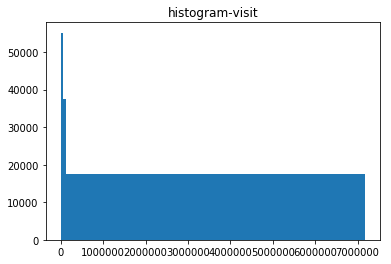

In [7]:
# 直方图
print('The histogram of visit:')
hist_visit, bins_visit = np.histogram(visit, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
print(hist_visit)
print(bins_visit)
print("The number of outlier of visit is:", hist_visit[-1])
plt.hist(visit, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
plt.title("histogram-visit")
plt.show()

The histogram of visitor:
[55142 55172 55157 34993 20165]
[5.000000e+01 3.430000e+03 6.541000e+03 1.309900e+04 2.760250e+04
 6.113949e+06]
The number of outlier of visitor is: 20165


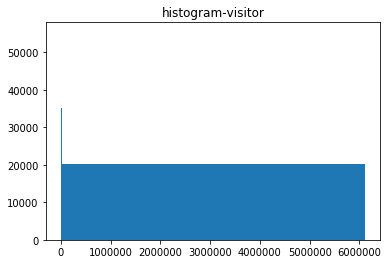

In [8]:
print('The histogram of visitor:')
hist_visitor, bins_visitor = np.histogram(visitor, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
print(hist_visitor)
print(bins_visitor)
print("The number of outlier of visitor is:", hist_visitor[-1])
plt.hist(visitor, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
plt.title("histogram-visitor")
plt.show()

The histogram of distance:
[55124 55129 55135 29384 25746]
[7.060000e+02 8.584000e+03 1.461400e+04 3.139800e+04 6.561900e+04
 6.297845e+06]
The number of outlier of distance is: 25746


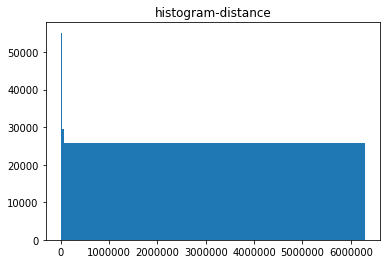

In [9]:
print('The histogram of distance:')
hist_distance, bins_distance = np.histogram(distance, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
print(hist_distance)
print(bins_distance)
print("The number of outlier of distance is:", hist_distance[-1])
plt.hist(distance, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
plt.title("histogram-distance")
plt.show()

The histogram of hour[ 1 ]:
[55115 55192 55149 41440 13733]
[     0.    1115.    1706.    2678.    5022.5 408076. ]
The number of outlier of hour[ 1 ]: 13733


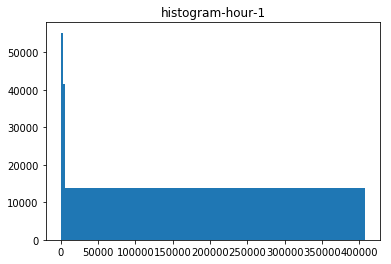

The histogram of hour[ 2 ]:
[55100 55134 55209 41712 13474]
[     0.    1059.    1611.    2512.    4691.5 414620. ]
The number of outlier of hour[ 2 ]: 13474


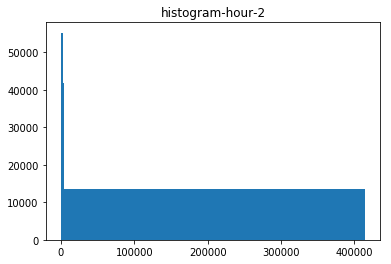

The histogram of hour[ 3 ]:
[55146 55092 55234 41688 13469]
[     0.     1033.     1567.     2439.5    4549.25 415050.  ]
The number of outlier of hour[ 3 ]: 13469


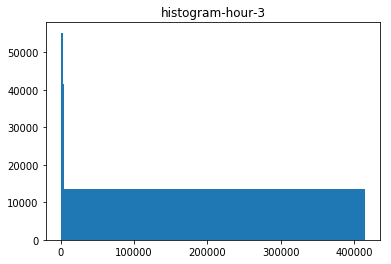

The histogram of hour[ 4 ]:
[55055 55190 55220 41678 13486]
[     0.   1024.   1556.   2428.   4534. 423863.]
The number of outlier of hour[ 4 ]: 13486


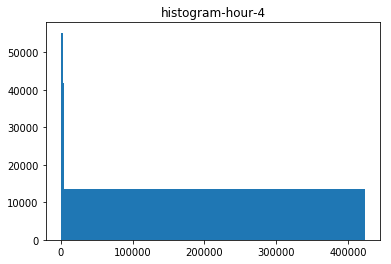

The histogram of hour[ 5 ]:
[55086 55169 55213 41363 13798]
[     0.    1053.    1614.    2548.    4790.5 389655. ]
The number of outlier of hour[ 5 ]: 13798


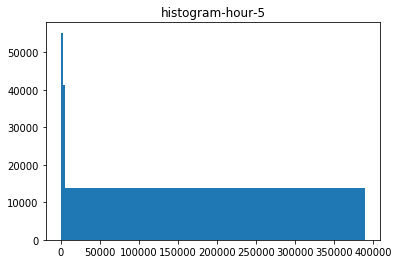

The histogram of hour[ 6 ]:
[55073 55197 55181 40473 14705]
[     0.    1152.    1789.    2885.    5484.5 374855. ]
The number of outlier of hour[ 6 ]: 14705


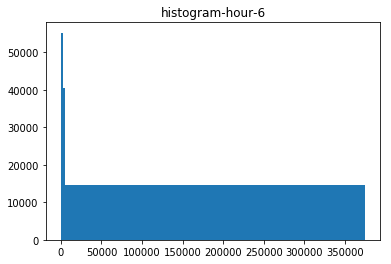

The histogram of hour[ 7 ]:
[55138 55131 55202 39112 16046]
[     0.    1395.    2232.    3744.    7267.5 374740. ]
The number of outlier of hour[ 7 ]: 16046


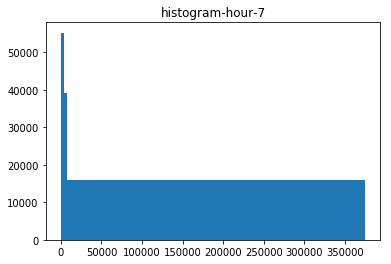

The histogram of hour[ 8 ]:
[55144 55143 55175 39599 15568]
[     0.   1867.   3115.   5353.  10582. 392794.]
The number of outlier of hour[ 8 ]: 15568


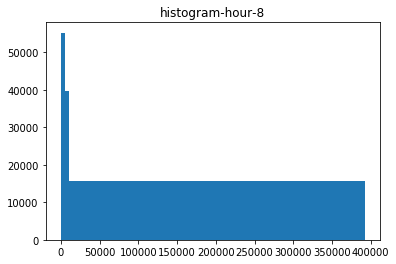

The histogram of hour[ 9 ]:
[55098 55183 55186 38613 16549]
[2.00000e+00 1.64200e+03 2.75800e+03 4.82200e+03 9.59200e+03 4.21881e+05]
The number of outlier of hour[ 9 ]: 16549


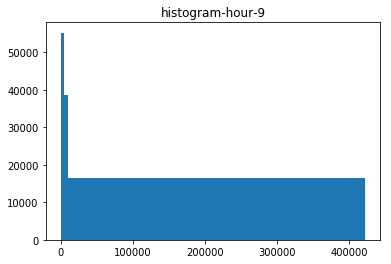

The histogram of hour[ 10 ]:
[55095 55175 55192 38168 16999]
[2.00000e+00 1.48600e+03 2.49900e+03 4.41200e+03 8.80100e+03 4.52308e+05]
The number of outlier of hour[ 10 ]: 16999


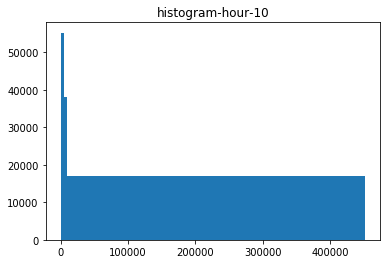

The histogram of hour[ 11 ]:
[55121 55168 55163 38031 17146]
[2.0000e+00 1.4780e+03 2.5030e+03 4.4660e+03 8.9480e+03 4.6041e+05]
The number of outlier of hour[ 11 ]: 17146


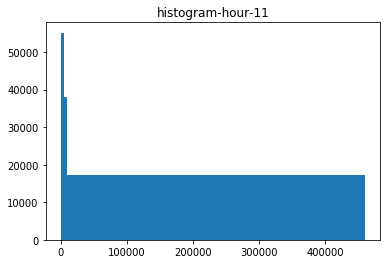

The histogram of hour[ 12 ]:
[55128 55143 55199 37900 17259]
[3.00000e+00 1.53000e+03 2.62200e+03 4.73600e+03 9.54500e+03 4.77597e+05]
The number of outlier of hour[ 12 ]: 17259


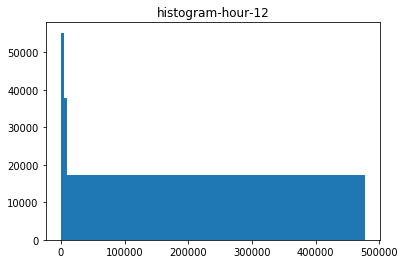

The histogram of hour[ 13 ]:
[55134 55147 55179 37872 17297]
[     0.    1598.    2764.    5027.   10170.5 464389. ]
The number of outlier of hour[ 13 ]: 17297


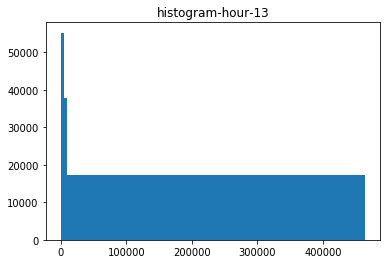

The histogram of hour[ 14 ]:
[55115 55180 55175 37725 17434]
[     0.   1589.   2745.   4993.  10099. 447290.]
The number of outlier of hour[ 14 ]: 17434


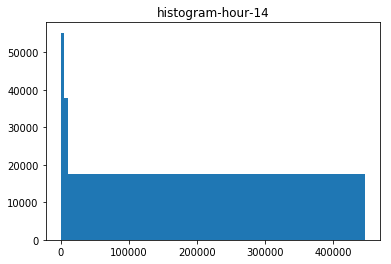

The histogram of hour[ 15 ]:
[55131 55153 55179 38233 16933]
[     0.   1731.   2975.   5343.  10761. 442044.]
The number of outlier of hour[ 15 ]: 16933


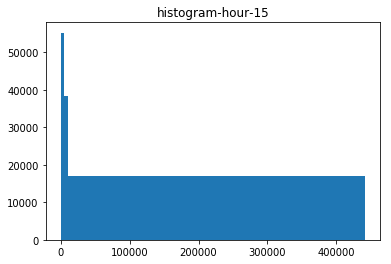

The histogram of hour[ 16 ]:
[55129 55185 55149 38679 16487]
[     0.   1949.   3323.   5903.  11834. 428866.]
The number of outlier of hour[ 16 ]: 16487


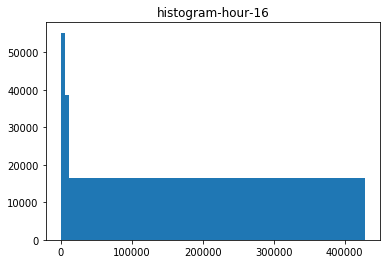

The histogram of hour[ 17 ]:
[55120 55176 55164 38367 16802]
[     0.   1986.   3384.   6022.  12076. 411195.]
The number of outlier of hour[ 17 ]: 16802


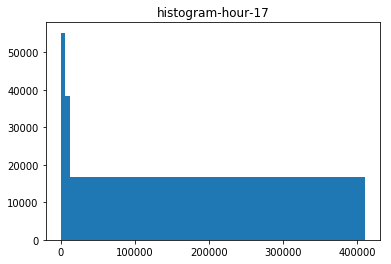

The histogram of hour[ 18 ]:
[55132 55181 55152 38636 16528]
[     0.   2055.   3497.   6185.  12380. 394592.]
The number of outlier of hour[ 18 ]: 16528


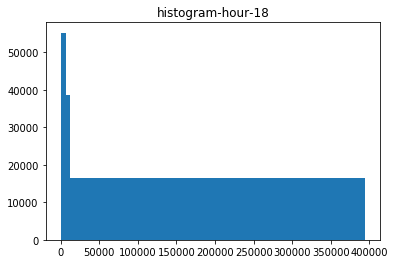

The histogram of hour[ 19 ]:
[55135 55174 55159 38824 16337]
[     0.    1894.    3183.    5535.   10996.5 341999. ]
The number of outlier of hour[ 19 ]: 16337


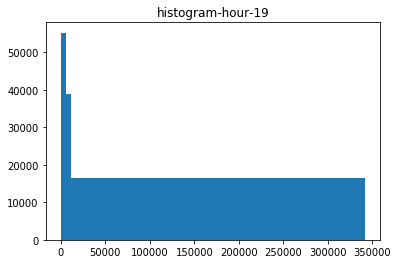

The histogram of hour[ 20 ]:
[55097 55190 55185 39202 15955]
[     0.     1692.     2784.     4750.5    9338.25 293178.  ]
The number of outlier of hour[ 20 ]: 15955


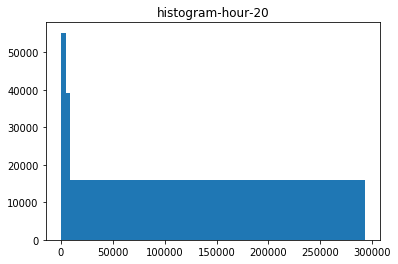

The histogram of hour[ 21 ]:
[55148 55119 55205 39641 15516]
[     0.     1567.     2522.     4204.5    8160.75 374411.  ]
The number of outlier of hour[ 21 ]: 15516


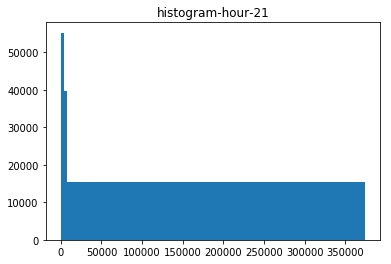

The histogram of hour[ 22 ]:
[55096 55204 55155 40035 15139]
[     0.    1457.    2304.    3756.    7204.5 377200. ]
The number of outlier of hour[ 22 ]: 15139


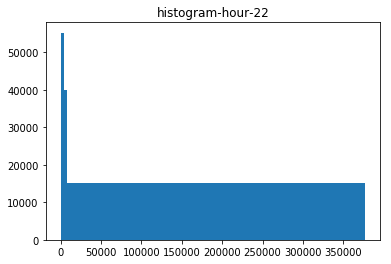

The histogram of hour[ 23 ]:
[55082 55232 55156 40539 14620]
[     0.    1324.    2067.    3319.    6311.5 379644. ]
The number of outlier of hour[ 23 ]: 14620


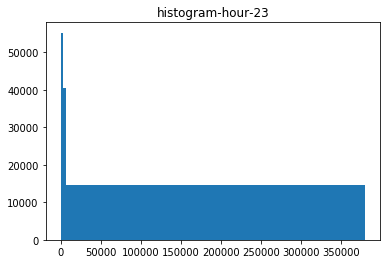

The histogram of hour[ 24 ]:
[55141 55138 55165 40986 14199]
[     0.    1206.    1861.    2957.    5583.5 396279. ]
The number of outlier of hour[ 24 ]: 14199


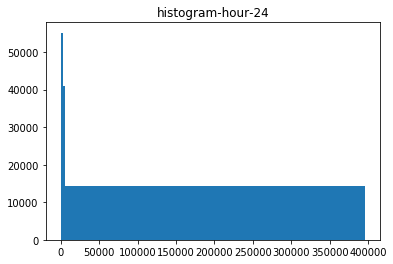

In [10]:
for i in range(24):
    print("The histogram of hour[", str(i+1), "]:")
    hist_hour, bins_hour = np.histogram(hour[i], bins=[mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], max_limit_hour[i], maxs_hour[i]])
    print(hist_hour)
    print(bins_hour)
    print("The number of outlier of hour[", str(i+1), "]:", hist_hour[-1])
    plt.hist(hour[i], bins=[mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], max_limit_hour[i], maxs_hour[i]])
    title = "histogram-hour-"+str(i+1)
    plt.title(title)
    plt.show()

The histogram of day[ 1 ]:
[55138 55162 55171 37807 17351]
[      0.     2665.     4797.     8826.    18067.5 1323997. ]
The number of outlier of day[ 1 ]: 17351


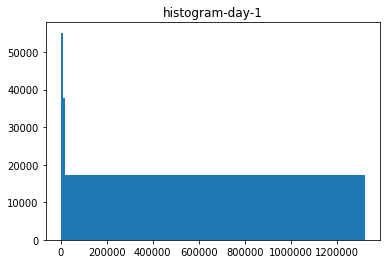

The histogram of day[ 2 ]:
[55155 55153 55160 37930 17231]
[      0.    2712.    4903.    9040.   18532. 1209115.]
The number of outlier of day[ 2 ]: 17231


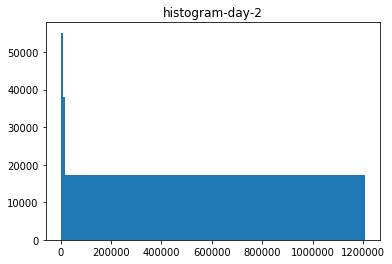

The histogram of day[ 3 ]:
[55140 55163 55167 38047 17112]
[     0.   2694.   4868.   8982.  18414. 953888.]
The number of outlier of day[ 3 ]: 17112


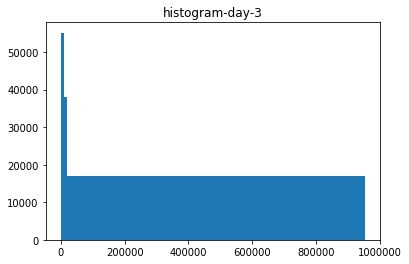

The histogram of day[ 4 ]:
[55150 55161 55160 37731 17427]
[3.00000e+00 2.22100e+03 4.03600e+03 7.48400e+03 1.53785e+04 9.50061e+05]
The number of outlier of day[ 4 ]: 17427


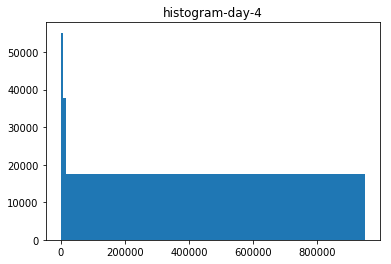

The histogram of day[ 5 ]:
[55144 55160 55161 37609 17555]
[     0.   2454.   4455.   8314.  17104. 894701.]
The number of outlier of day[ 5 ]: 17555


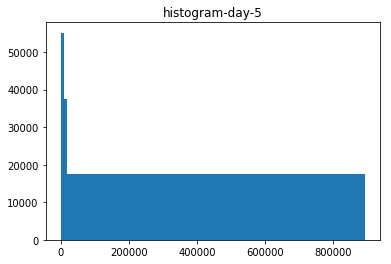

The histogram of day[ 6 ]:
[55142 55163 55167 36678 18479]
[     0.     2204.     3959.     7429.5   15267.75 898361.  ]
The number of outlier of day[ 6 ]: 18479


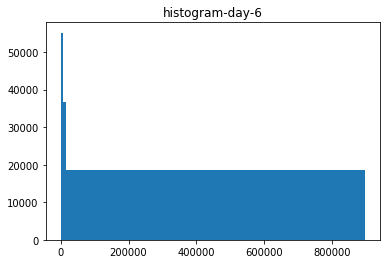

The histogram of day[ 7 ]:
[55154 55131 55187 36308 18849]
[     0.     1988.     3513.     6527.5   13336.75 949777.  ]
The number of outlier of day[ 7 ]: 18849


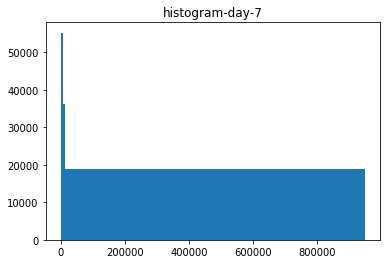

In [11]:
for i in range(7):
    print("The histogram of day[", str(i+1), "]:")
    hist_day, bins_day = np.histogram(day[i], bins=[mins_day[i], Q1_day[i], median_day[i], Q3_day[i], max_limit_day[i], maxs_day[i]])
    print(hist_day)
    print(bins_day)
    print("The number of outlier of day[", str(i+1), "]:", hist_day[-1])
    plt.hist(day[i], bins=[mins_day[i], Q1_day[i], median_day[i], Q3_day[i], max_limit_day[i], maxs_day[i]])
    title = "histogram-day-"+str(i+1)
    plt.title(title)
    plt.show()

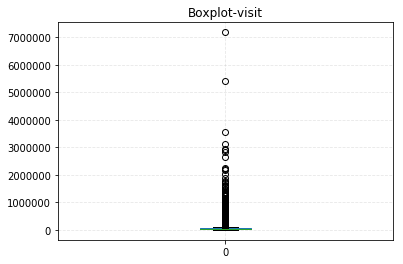

In [12]:
# 盒图
df = pd.DataFrame(visit)
# print(df.describe())
df.plot.box(title="Boxplot-visit")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

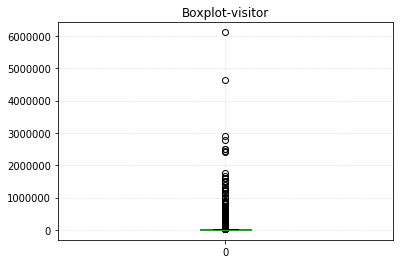

In [13]:
df = pd.DataFrame(visitor)
# print(df.describe())
df.plot.box(title="Boxplot-visitor")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

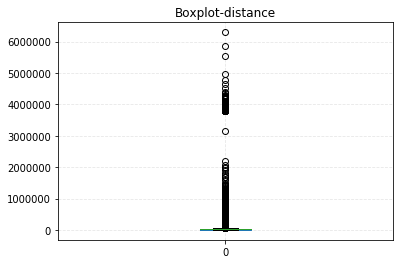

In [14]:
df = pd.DataFrame(distance)
# print(df.describe())
df.plot.box(title="Boxplot-distance")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

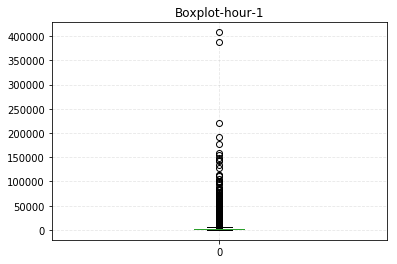

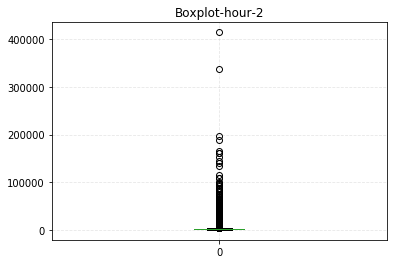

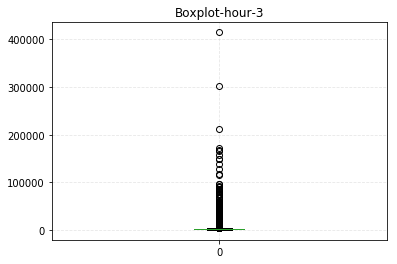

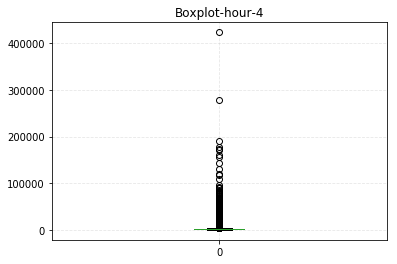

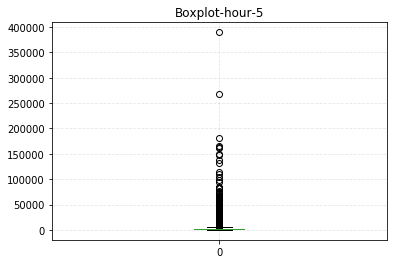

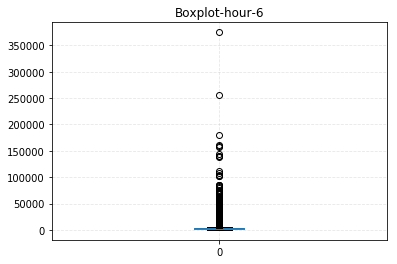

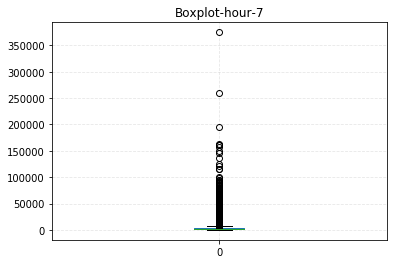

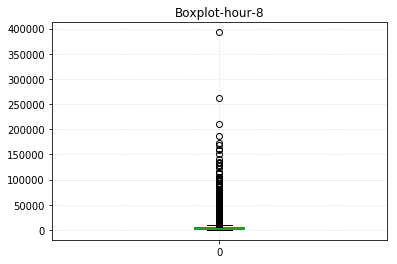

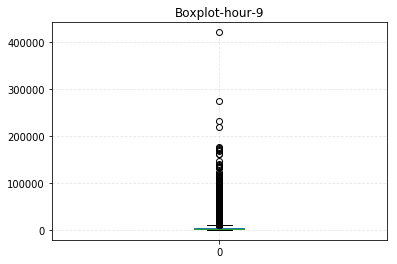

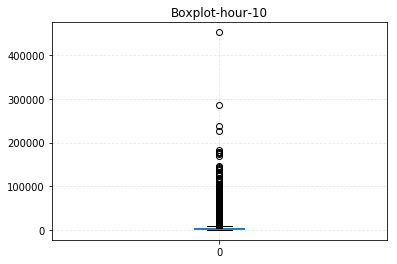

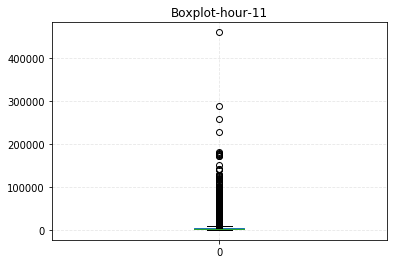

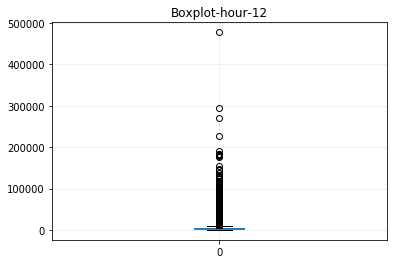

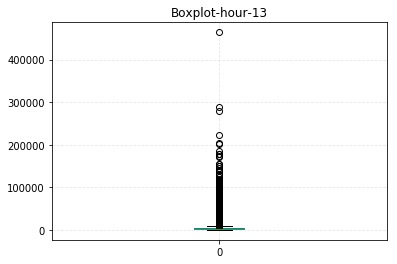

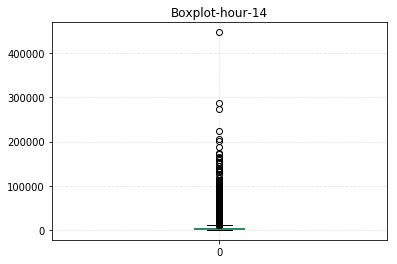

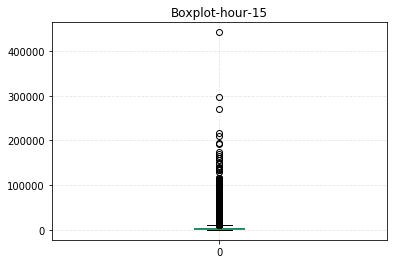

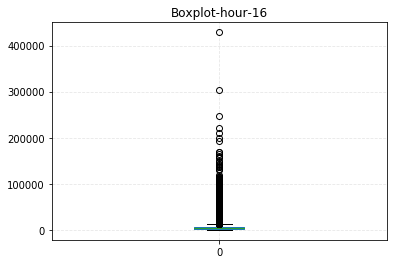

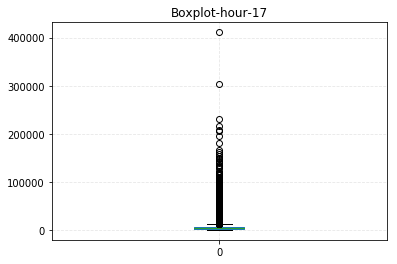

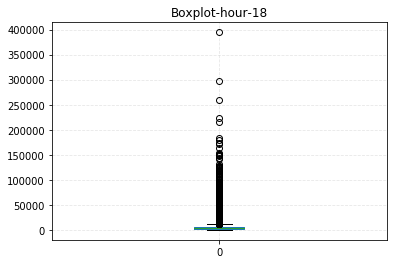

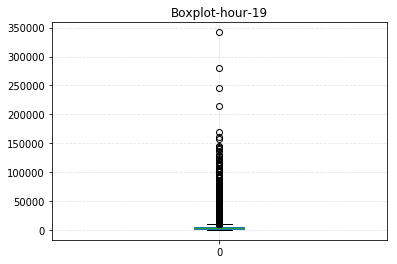

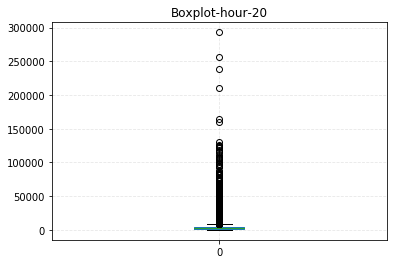

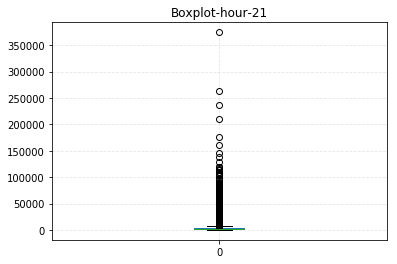

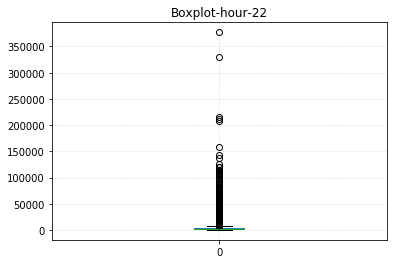

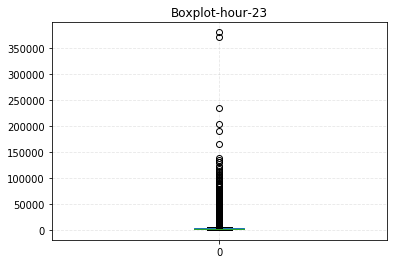

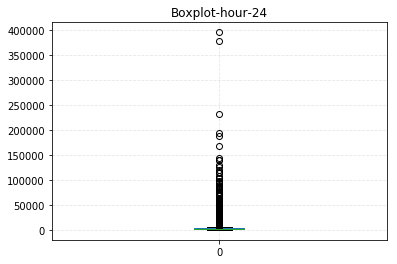

In [15]:
for i in range(24):
    df = pd.DataFrame(hour[i])
    # print(df.describe())
    title = "Boxplot-hour-" + str(i + 1)
    df.plot.box(title=title)
    plt.grid(linestyle="--", alpha=0.3)
    plt.show()

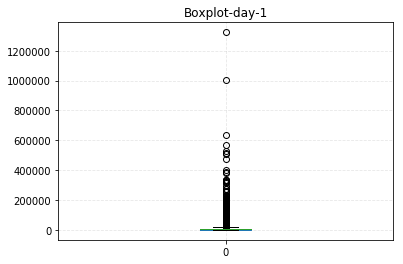

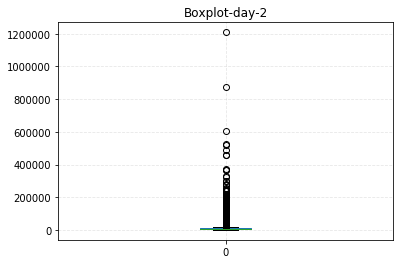

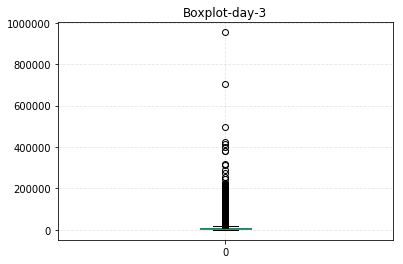

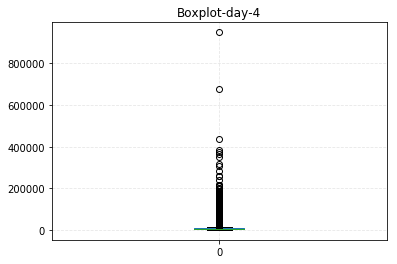

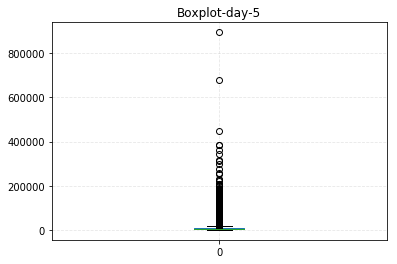

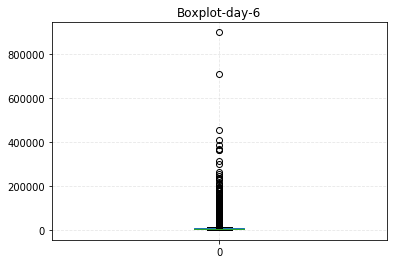

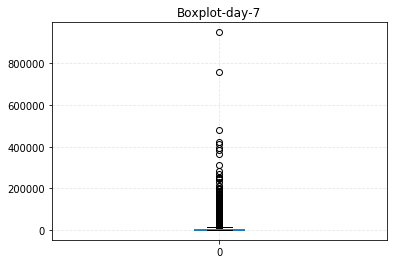

In [16]:
for i in range(7):
    df = pd.DataFrame(day[i])
    # print(df.describe())
    title = "Boxplot-day-" + str(i + 1)
    df.plot.box(title=title)
    plt.grid(linestyle="--", alpha=0.3)
    plt.show()

数据缺失的处理

1）将缺失部分剔除，若有一项数据为空 则删除一行数据项；

In [17]:
print('Processing missing data')
visit_new = list()
visitor_new = list()
distance_new = list()
hour_new = [[] for i in range(24)]
day_new = [[] for i in range(7)]

with open(filename, 'r') as fins:
    reader = csv.reader(fins)
    rownum = 0

    # 每一行数据
    for line in reader:
        if header and rownum == 0:
            header = line
            print('header: ', header)
        else:
            # 若有一项数据为空 则删除一行数据项
            if line[0] and line[1] and line[2] and  line[3] and line[4] \
                    and line[5]!='{}' and line[6]!='{}' and line[7] \
                    and line[8]!='[]' and line[9]!='[]' and line[10]!='[]' \
                    and line[11]!='[]' and line[12]!='{}':
                visit_new.append(float(line[3]))
                visitor_new.append(float(line[4]))
                distance_new.append(float(line[7]))

                ph = line[11].strip('[').strip(']').split(',')
                for i in range(24):
                    hour_new[i].append(int(ph[i]))

                pdd = json.loads(line[12])
                i = 0
                for v in pdd.values():
                    day_new[i].append(int(v))
                    i += 1

        rownum += 1
        # if rownum == 4:
        #     break

Processing missing data
header:  ['\ufeffcensus_block_group', 'date_range_start', 'date_range_end', 'raw_visit_count', 'raw_visitor_count', 'visitor_home_cbgs', 'visitor_work_cbgs', 'distance_from_home', 'related_same_day_brand', 'related_same_month_brand', 'top_brands', 'popularity_by_hour', 'popularity_by_day']


In [18]:
visit_new = np.array(visit_new)
visitor_new = np.array(visitor_new)
distance_new = np.array(distance_new)
visit_new.sort()
visitor_new.sort()
distance_new.sort()
for i in range(24):
    hour_new[i] = np.array(hour_new[i])
    hour_new[i].sort()
for i in range(7):
    day_new[i] = np.array(day_new[i])
    day_new[i].sort()

可视化比较

In [19]:
print("========================== Visual data analysis for deleting ==========================")
print("========================== visit ==========================")
mins_visit = visit_new[0]
maxs_visit = visit_new[-1]
median_visit = np.median(visit_new)
Q1_visit = my_quantile(visit_new, 0.25)
Q3_visit = my_quantile(visit_new, 0.75)
print("Five number summary of visit: min, Q1, median, Q3, max")
print(mins_visit, Q1_visit, median_visit, Q3_visit, maxs_visit)
IQR_visit = Q3_visit - Q1_visit
min_limit_visit = Q1_visit - (1.5 * IQR_visit)
max_limit_visit = Q3_visit + (1.5 * IQR_visit)
print("IQR of visit:", IQR_visit)
print("The reasonable interval of visit:", min_limit_visit, max_limit_visit)

print("========================== visitor ==========================")
mins_visitor = visitor_new[0]
maxs_visitor = visitor_new[-1]
median_visitor = np.median(visitor_new)
Q1_visitor = my_quantile(visitor_new, 0.25)
Q3_visitor = my_quantile(visitor_new, 0.75)
print("Five number summary of visitor: min, Q1, median, Q3, max")
print(mins_visitor, Q1_visitor, median_visitor, Q3_visitor, maxs_visitor)
IQR_visitor = Q3_visitor - Q1_visitor
min_limit_visitor = Q1_visitor - (1.5 * IQR_visitor)
max_limit_visitor = Q3_visitor + (1.5 * IQR_visitor)
print("IQR of visitor:", IQR_visitor)
print("The reasonable interval of visitor:", min_limit_visitor, max_limit_visitor)

print("========================== distance ==========================")
mins_distance = distance_new[0]
maxs_distance = distance_new[-1]
median_distance = np.median(distance_new)
Q1_distance = my_quantile(distance_new, 0.25)
Q3_distance = my_quantile(distance_new, 0.75)
print("Five number summary of distance: min, Q1, median, Q3, max")
print(mins_distance, Q1_distance, median_distance, Q3_distance, maxs_distance)
IQR_distance = Q3_distance - Q1_distance
min_limit_distance = Q1_distance - (1.5 * IQR_distance)
max_limit_distance = Q3_distance + (1.5 * IQR_distance)
print("IQR of distance:", IQR_distance)
print("The reasonable interval of distance:", min_limit_distance, max_limit_distance)

print("========================== hour ==========================")
for i in range(24):
    mins_hour[i] = hour_new[i][0]
    maxs_hour[i] = hour_new[i][-1]
    median_hour[i] = np.median(hour_new[i])
    Q1_hour[i] = my_quantile(hour_new[i], 0.25)
    Q3_hour[i] = my_quantile(hour_new[i], 0.75)
    print("Five number summary of hour[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], maxs_hour[i])
    IQR_hour[i] = Q3_hour[i] - Q1_hour[i]
    min_limit_hour[i] = Q1_hour[i] - (1.5 * IQR_hour[i])
    max_limit_hour[i] = Q3_hour[i] + (1.5 * IQR_hour[i])
    print("IQR of hour[", str(i + 1), "]:", IQR_hour[i])
    print("The reasonable interval of hour[", str(i + 1), "]:", min_limit_hour[i], max_limit_hour[i])

print("========================== day ==========================")
for i in range(7):
    mins_day[i] = day_new[i][0]
    maxs_day[i] = day_new[i][-1]
    median_day[i] = np.median(day_new[i])
    Q1_day[i] = my_quantile(day_new[i], 0.25)
    Q3_day[i] = my_quantile(day_new[i], 0.75)
    print("Five number summary of day[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_day[i], Q1_day[i], median_day[i], Q3_day[i], maxs_day[i])
    IQR_day[i] = Q3_day[i] - Q1_day[i]
    min_limit_day[i] = Q1_day[i] - (1.5 * IQR_day[i])
    max_limit_day[i] = Q3_day[i] + (1.5 * IQR_day[i])
    print("IQR of day[", str(i + 1), "]:", IQR_day[i])
    print("The reasonable interval of day[", str(i + 1), "]:", min_limit_day[i], max_limit_day[i])


========================== Visual data analysis for deleting ==========================
========================== visit ==========================
Five number summary of visit: min, Q1, median, Q3, max
2334.0 28142.0 43365.5 71895.5 1340323.0
IQR of visit: 43753.5
The reasonable interval of visit: -37488.25 137525.75
========================== visitor ==========================
Five number summary of visitor: min, Q1, median, Q3, max
334.0 5621.0 9233.5 16367.25 353611.0
IQR of visitor: 10746.25
The reasonable interval of visitor: -10498.375 32486.625
========================== distance ==========================
Five number summary of distance: min, Q1, median, Q3, max
1178.0 9826.0 16085.0 33876.0 4218226.0
IQR of distance: 24050.0
The reasonable interval of distance: -26249.0 69951.0
========================== hour ==========================
Five number summary of hour[ 1 ]: min, Q1, median, Q3, max
9 1408.0 2053.0 3079.0 178070
IQR of hour[ 1 ]: 1671.0
The reasonable interval of h

直方图和盒图

The histogram of visit:
[24368 24371 24370 17389  6980]
[   2334.     28142.     43365.5    71895.5   137525.75 1340323.  ]
The number of outlier of visit is: 6980


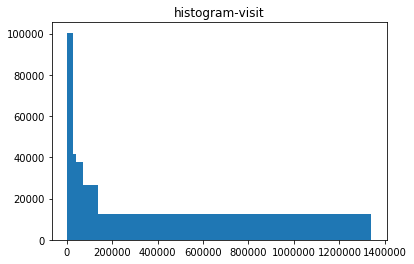

The histogram of visitor:
[24366 24373 24370 16330  8039]
[3.3400000e+02 5.6210000e+03 9.2335000e+03 1.6367250e+04 3.2486625e+04
 3.5361100e+05]
The number of outlier of visitor is: 8039


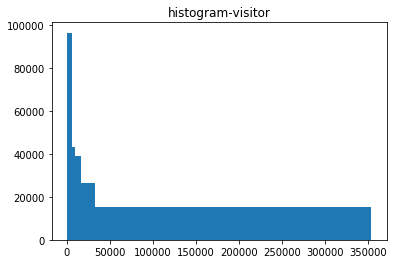

The histogram of distance:
[24366 24371 24371 12760 11610]
[1.178000e+03 9.826000e+03 1.608500e+04 3.387600e+04 6.995100e+04
 4.218226e+06]
The number of outlier of distance is: 11610


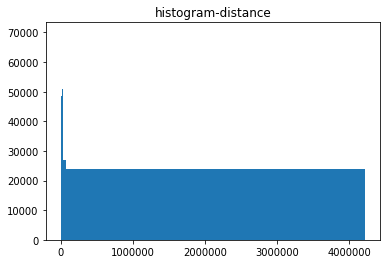

In [21]:
# 直方图
print('The histogram of visit:')
hist_visit, bins_visit = np.histogram(visit_new, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
print(hist_visit)
print(bins_visit)
print("The number of outlier of visit is:", hist_visit[-1])
plt.hist(visit, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
plt.title("histogram-visit")
plt.show()

print('The histogram of visitor:')
hist_visitor, bins_visitor = np.histogram(visitor_new, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
print(hist_visitor)
print(bins_visitor)
print("The number of outlier of visitor is:", hist_visitor[-1])
plt.hist(visitor, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
plt.title("histogram-visitor")
plt.show()

print('The histogram of distance:')
hist_distance, bins_distance = np.histogram(distance_new, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
print(hist_distance)
print(bins_distance)
print("The number of outlier of distance is:", hist_distance[-1])
plt.hist(distance, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
plt.title("histogram-distance")
plt.show()

The histogram of hour[ 1 ]:
[24336 24400 24358 18462  5922]
[9.0000e+00 1.4080e+03 2.0530e+03 3.0790e+03 5.5855e+03 1.7807e+05]
The number of outlier of hour[ 1 ]: 5922


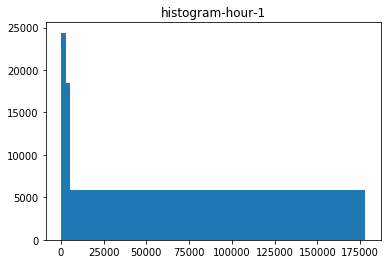

The histogram of hour[ 2 ]:
[24364 24333 24408 18478  5895]
[8.0000e+00 1.3200e+03 1.9200e+03 2.8790e+03 5.2175e+03 1.6085e+05]
The number of outlier of hour[ 2 ]: 5895


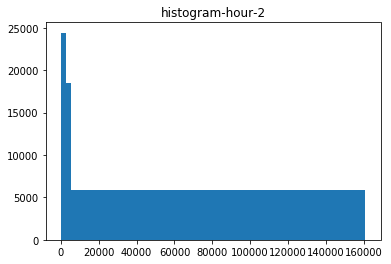

The histogram of hour[ 3 ]:
[24358 24356 24392 18498  5874]
[9.00000e+00 1.28000e+03 1.86200e+03 2.80000e+03 5.08000e+03 1.49289e+05]
The number of outlier of hour[ 3 ]: 5874


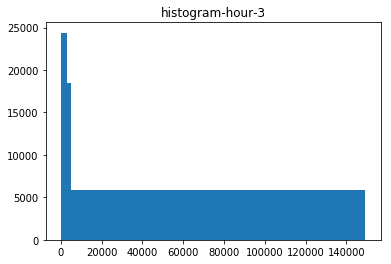

The histogram of hour[ 4 ]:
[24365 24343 24395 18516  5859]
[5.00000e+00 1.26900e+03 1.85200e+03 2.79300e+03 5.07900e+03 1.42599e+05]
The number of outlier of hour[ 4 ]: 5859


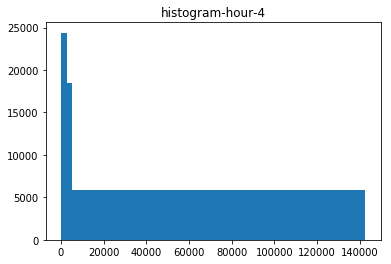

The histogram of hour[ 5 ]:
[24335 24372 24395 18549  5827]
[4.00000e+00 1.31600e+03 1.93700e+03 2.94400e+03 5.38600e+03 1.38577e+05]
The number of outlier of hour[ 5 ]: 5827


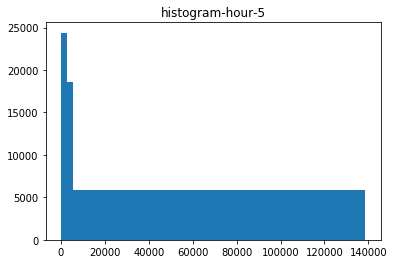

The histogram of hour[ 6 ]:
[24345 24373 24379 18322  6059]
[8.00000e+00 1.48800e+03 2.20000e+03 3.37700e+03 6.21050e+03 1.39757e+05]
The number of outlier of hour[ 6 ]: 6059


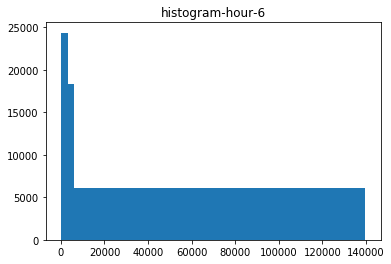

The histogram of hour[ 7 ]:
[24353 24360 24388 17909  6468]
[5.10000e+01 1.90700e+03 2.84700e+03 4.48800e+03 8.35950e+03 1.60728e+05]
The number of outlier of hour[ 7 ]: 6468


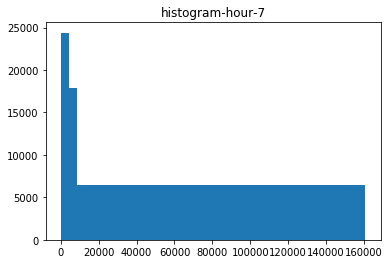

The histogram of hour[ 8 ]:
[24363 24373 24370 18096  6276]
[   218.   2745.   4118.   6529.  12205. 186191.]
The number of outlier of hour[ 8 ]: 6276


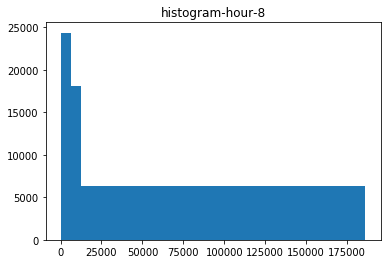

The histogram of hour[ 9 ]:
[24346 24376 24387 17670  6699]
[   224.      2453.      3700.      5925.25   11133.625 218589.   ]
The number of outlier of hour[ 9 ]: 6699


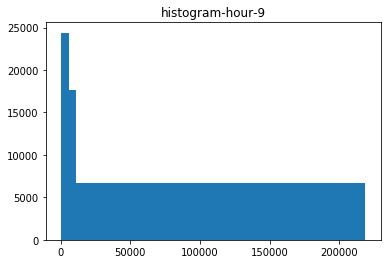

The histogram of hour[ 10 ]:
[24367 24356 24382 17654  6719]
[1.67000e+02 2.25900e+03 3.43600e+03 5.56800e+03 1.05315e+04 2.38403e+05]
The number of outlier of hour[ 10 ]: 6719


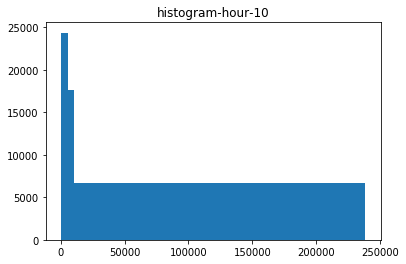

The histogram of hour[ 11 ]:
[24362 24364 24383 17584  6785]
[1.7400000e+02 2.2890000e+03 3.5050000e+03 5.7132500e+03 1.0849625e+04
 2.5777000e+05]
The number of outlier of hour[ 11 ]: 6785


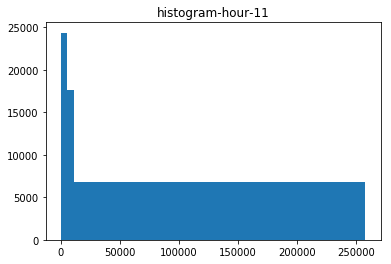

The histogram of hour[ 12 ]:
[24369 24351 24385 17546  6827]
[1.7200000e+02 2.4257500e+03 3.7290000e+03 6.1190000e+03 1.1658875e+04
 2.7101200e+05]
The number of outlier of hour[ 12 ]: 6827


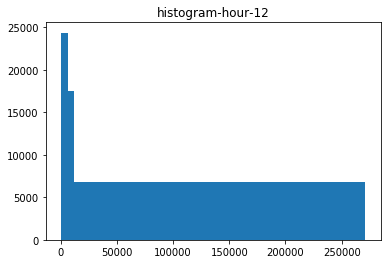

The histogram of hour[ 13 ]:
[24360 24370 24378 17584  6786]
[1.75000e+02 2.57300e+03 3.97700e+03 6.53800e+03 1.24855e+04 2.79497e+05]
The number of outlier of hour[ 13 ]: 6786


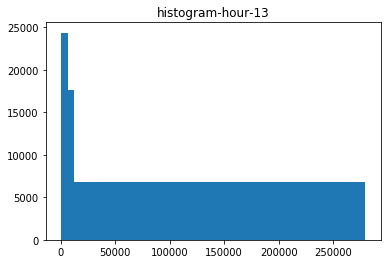

The histogram of hour[ 14 ]:
[24339 24389 24379 17489  6882]
[1.90000e+02 2.54200e+03 3.92600e+03 6.46900e+03 1.23595e+04 2.87922e+05]
The number of outlier of hour[ 14 ]: 6882


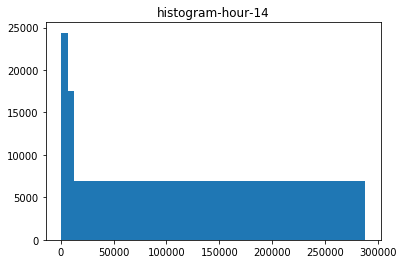

The histogram of hour[ 15 ]:
[24358 24374 24374 17630  6742]
[1.83000e+02 2.74000e+03 4.19800e+03 6.83900e+03 1.29875e+04 2.96167e+05]
The number of outlier of hour[ 15 ]: 6742


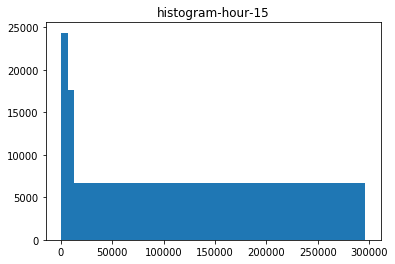

The histogram of hour[ 16 ]:
[24361 24371 24377 17689  6680]
[2.3000000e+02 3.0730000e+03 4.6480000e+03 7.4922500e+03 1.4121125e+04
 3.0378100e+05]
The number of outlier of hour[ 16 ]: 6680


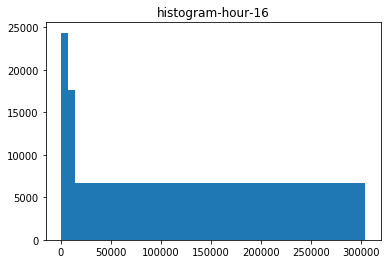

The histogram of hour[ 17 ]:
[24345 24387 24377 17645  6724]
[1.8600000e+02 3.1330000e+03 4.7360000e+03 7.6722500e+03 1.4481125e+04
 3.0446100e+05]
The number of outlier of hour[ 17 ]: 6724


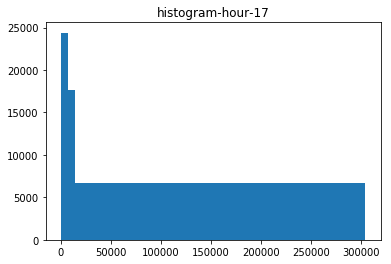

The histogram of hour[ 18 ]:
[24356 24370 24382 17803  6567]
[1.00000e+02 3.21400e+03 4.85900e+03 7.84000e+03 1.47790e+04 2.97204e+05]
The number of outlier of hour[ 18 ]: 6567


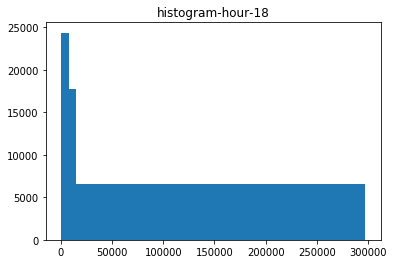

The histogram of hour[ 19 ]:
[24354 24379 24373 17817  6555]
[7.20000e+01 2.88900e+03 4.33700e+03 6.92000e+03 1.29665e+04 2.79644e+05]
The number of outlier of hour[ 19 ]: 6555


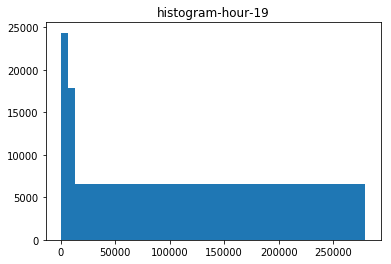

The histogram of hour[ 20 ]:
[24346 24385 24375 17910  6462]
[6.00000e+01 2.51100e+03 3.73600e+03 5.89400e+03 1.09685e+04 2.56353e+05]
The number of outlier of hour[ 20 ]: 6462


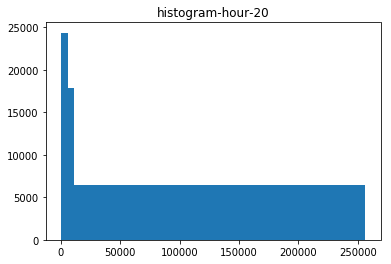

The histogram of hour[ 21 ]:
[24364 24371 24374 18071  6298]
[2.600000e+01 2.243000e+03 3.304000e+03 5.148250e+03 9.506125e+03
 2.368130e+05]
The number of outlier of hour[ 21 ]: 6298


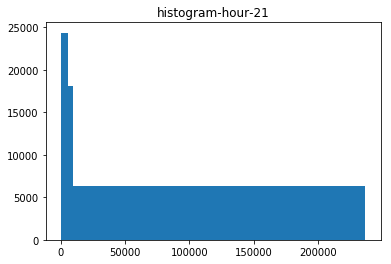

The histogram of hour[ 22 ]:
[24357 24374 24375 18207  6165]
[1.50000e+01 2.00800e+03 2.93700e+03 4.51400e+03 8.27300e+03 2.16387e+05]
The number of outlier of hour[ 22 ]: 6165


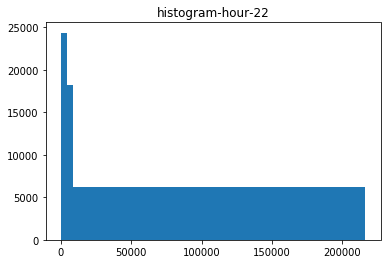

The histogram of hour[ 23 ]:
[24356 24378 24363 18282  6099]
[8.00000e+00 1.76400e+03 2.56900e+03 3.91000e+03 7.12900e+03 2.04195e+05]
The number of outlier of hour[ 23 ]: 6099


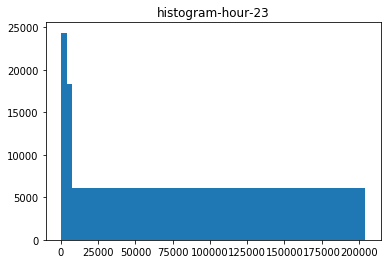

The histogram of hour[ 24 ]:
[24358 24381 24364 18331  6044]
[1.50000e+01 1.55800e+03 2.27250e+03 3.43000e+03 6.23800e+03 1.95288e+05]
The number of outlier of hour[ 24 ]: 6044


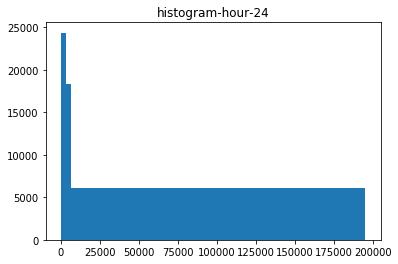

The histogram of day[ 1 ]:
[24359 24371 24375 17463  6910]
[   385.   4409.   6786.  11149.  21259. 205663.]
The number of outlier of day[ 1 ]: 6910


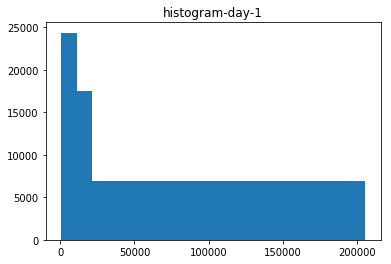

The histogram of day[ 2 ]:
[24356 24380 24368 17439  6935]
[   498.    4504.    6934.   11367.   21661.5 237654. ]
The number of outlier of day[ 2 ]: 6935


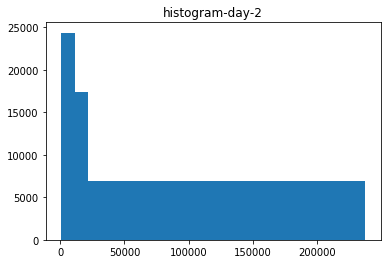

The histogram of day[ 3 ]:
[24369 24364 24374 17493  6878]
[   445.      4467.75    6879.     11311.     21575.875 253703.   ]
The number of outlier of day[ 3 ]: 6878


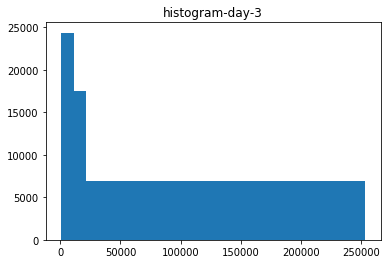

The histogram of day[ 4 ]:
[24364 24372 24372 17425  6945]
[   368.   3700.   5718.   9462.  18105. 209846.]
The number of outlier of day[ 4 ]: 6945


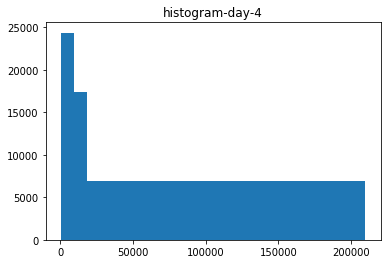

The histogram of day[ 5 ]:
[24366 24366 24377 17418  6951]
[   382.      4110.      6365.     10639.25   20433.125 203609.   ]
The number of outlier of day[ 5 ]: 6951


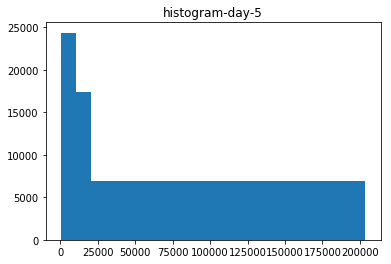

The histogram of day[ 6 ]:
[24361 24374 24372 17149  7222]
[2.20000e+01 3.62600e+03 5.65200e+03 9.57700e+03 1.85035e+04 1.91993e+05]
The number of outlier of day[ 6 ]: 7222


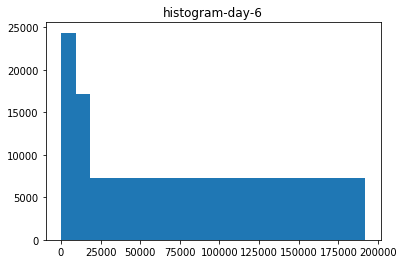

The histogram of day[ 7 ]:
[24357 24374 24377 17053  7317]
[2.70000e+01 3.16000e+03 4.91600e+03 8.37100e+03 1.61875e+04 1.85322e+05]
The number of outlier of day[ 7 ]: 7317


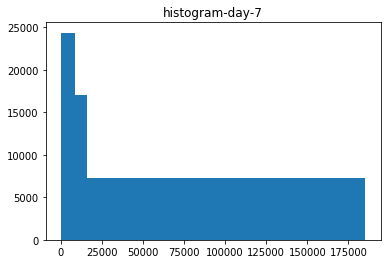

In [22]:
for i in range(24):
    print("The histogram of hour[", str(i+1), "]:")
    hist_hour, bins_hour = np.histogram(hour_new[i], bins=[mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], max_limit_hour[i], maxs_hour[i]])
    print(hist_hour)
    print(bins_hour)
    print("The number of outlier of hour[", str(i+1), "]:", hist_hour[-1])
    plt.hist(hour_new[i], bins=[mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], max_limit_hour[i], maxs_hour[i]])
    title = "histogram-hour-"+str(i+1)
    plt.title(title)
    plt.show()

for i in range(7):
    print("The histogram of day[", str(i+1), "]:")
    hist_day, bins_day = np.histogram(day_new[i], bins=[mins_day[i], Q1_day[i], median_day[i], Q3_day[i], max_limit_day[i], maxs_day[i]])
    print(hist_day)
    print(bins_day)
    print("The number of outlier of day[", str(i+1), "]:", hist_day[-1])
    plt.hist(day_new[i], bins=[mins_day[i], Q1_day[i], median_day[i], Q3_day[i], max_limit_day[i], maxs_day[i]])
    title = "histogram-day-"+str(i+1)
    plt.title(title)
    plt.show()

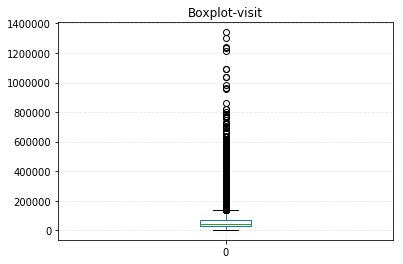

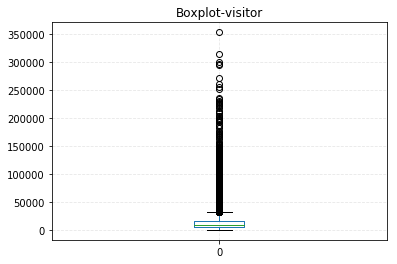

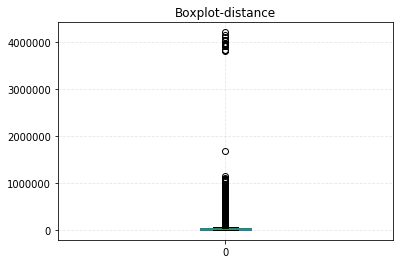

In [23]:
# 盒图
df = pd.DataFrame(visit_new)
# print(df.describe())
df.plot.box(title="Boxplot-visit")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(visitor_new)
# print(df.describe())
df.plot.box(title="Boxplot-visitor")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(distance_new)
# print(df.describe())
df.plot.box(title="Boxplot-distance")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

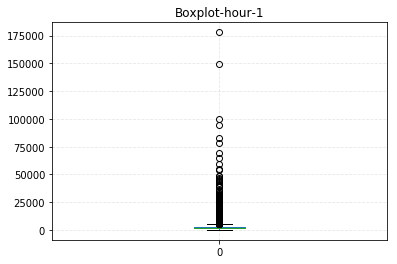

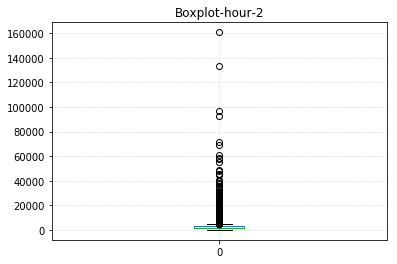

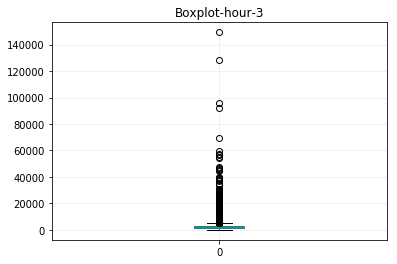

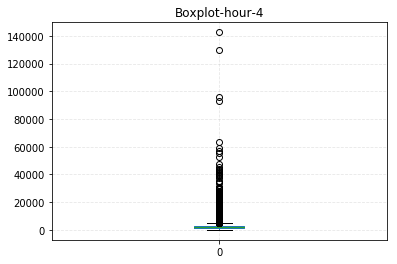

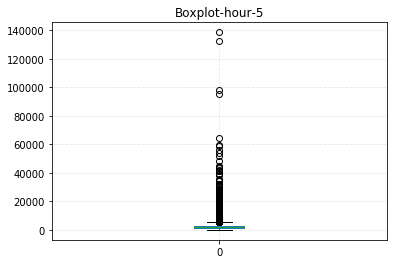

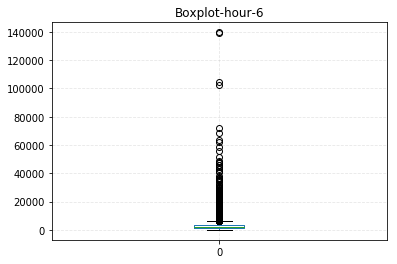

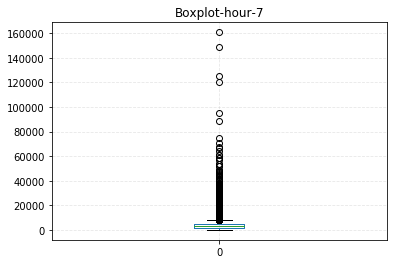

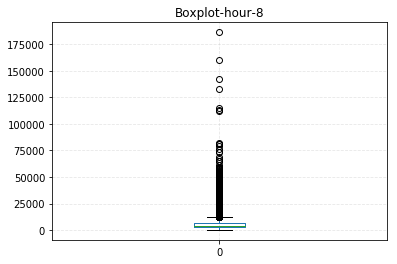

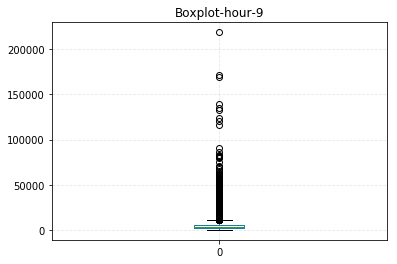

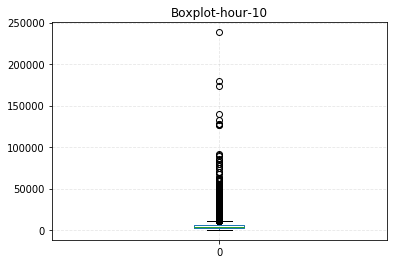

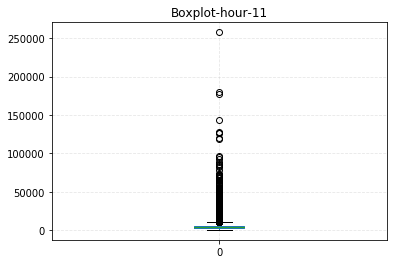

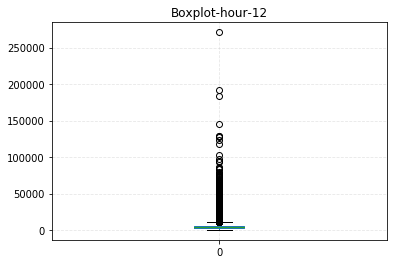

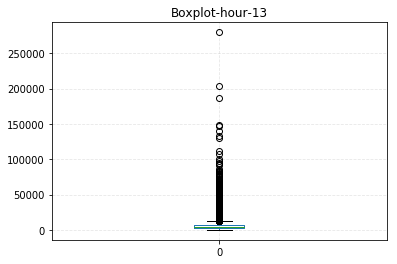

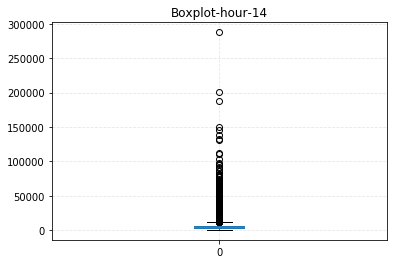

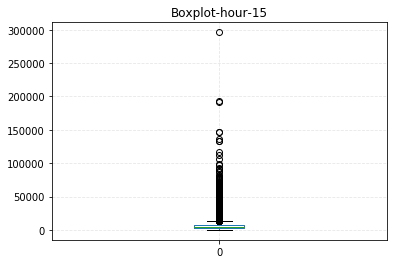

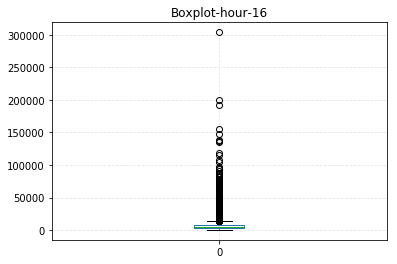

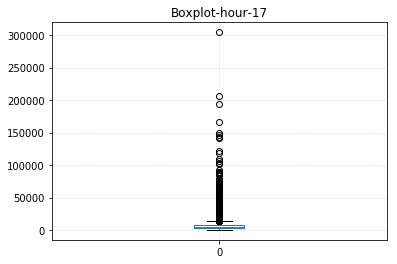

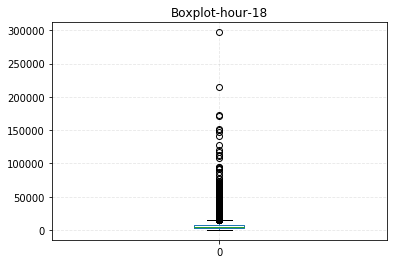

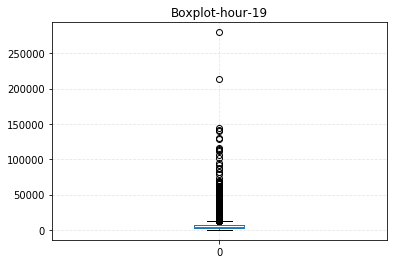

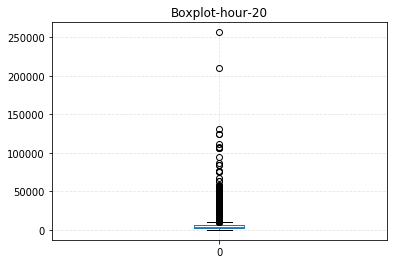

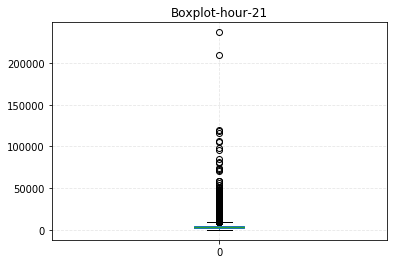

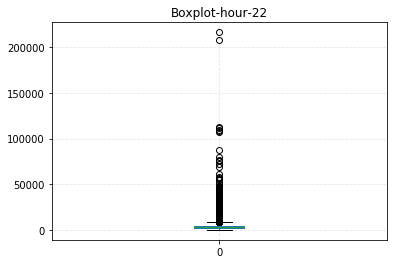

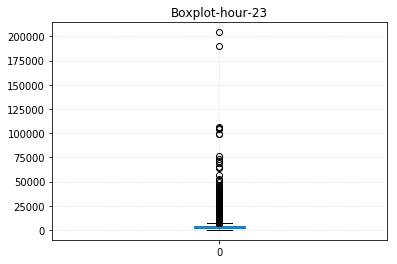

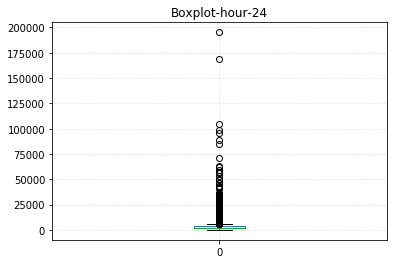

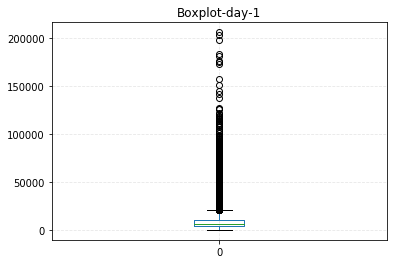

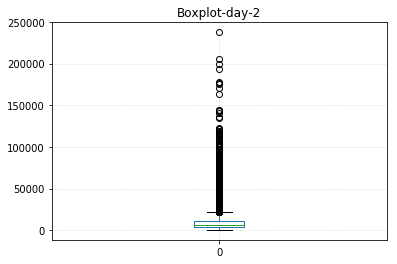

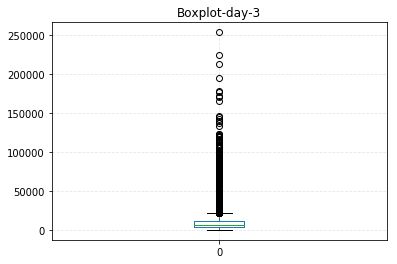

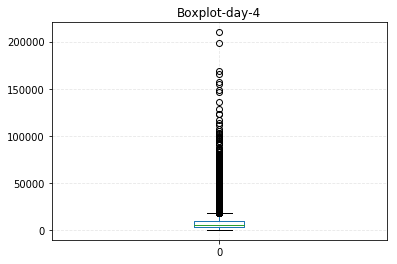

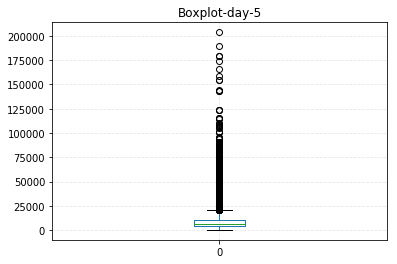

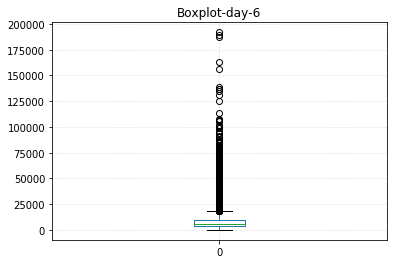

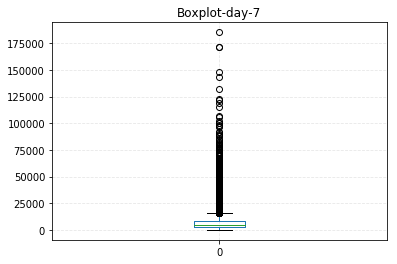

In [24]:
for i in range(24):
    df = pd.DataFrame(hour_new[i])
    # print(df.describe())
    title = "Boxplot-hour-" + str(i + 1)
    df.plot.box(title=title)
    plt.grid(linestyle="--", alpha=0.3)
    plt.show()

for i in range(7):
    df = pd.DataFrame(day_new[i])
    # print(df.describe())
    title = "Boxplot-day-" + str(i + 1)
    df.plot.box(title=title)
    plt.grid(linestyle="--", alpha=0.3)
    plt.show()

2）用最高频率值来填补缺失值

In [25]:
# visit
most_visit = stats.mode(visit)[0][0]
missing_data = [most_visit for i in range(missing_visit)]
visit_new = visit.tolist()
visit_new += missing_data
visit_new = np.array(visit_new)
visit_new.sort()
print("visit")
# visitor
most_visitor = stats.mode(visitor)[0][0]
missing_data = [most_visitor for i in range(missing_visitor)]
visitor_new = visitor.tolist()
visitor_new += missing_data
visitor_new = np.array(visitor_new)
visitor_new.sort()
print("visitor")
# distance
most_distance = stats.mode(distance)[0][0]
missing_data = [most_distance for i in range(missing_distance)]
distance_new = distance.tolist()
distance_new += missing_data
distance_new = np.array(distance_new)
distance_new.sort()
print("distance")
# hour
most_hour = [0 for i in range(24)]
for i in range(24):
    most_hour[i] = stats.mode(hour[i])[0][0]
    missing_data = [most_hour[i] for j in range(missing_hour)]
    hour_new[i] = hour[i].tolist()
    hour_new[i] += missing_data
    hour_new[i] = np.array(hour_new[i])
    hour_new[i].sort()
print("hour")
# day
most_day = [0 for i in range(7)]
for i in range(7):
    most_day[i] = stats.mode(day[i])[0][0]
    missing_data = [most_day[i] for j in range(missing_day)]
    day_new[i] = day[i].tolist()
    day_new[i] += missing_data
    day_new[i] = np.array(day_new[i])
    day_new[i].sort()
print("day")

visit
visitor
distance
hour
day


可视化比较

In [26]:
print("========================== visit ==========================")
mins_visit = visit_new[0]
maxs_visit = visit_new[-1]
median_visit = np.median(visit_new)
Q1_visit = my_quantile(visit_new, 0.25)
Q3_visit = my_quantile(visit_new, 0.75)
print("Five number summary of visit: min, Q1, median, Q3, max")
print(mins_visit, Q1_visit, median_visit, Q3_visit, maxs_visit)
IQR_visit = Q3_visit - Q1_visit
min_limit_visit = Q1_visit - (1.5 * IQR_visit)
max_limit_visit = Q3_visit + (1.5 * IQR_visit)
print("IQR of visit:", IQR_visit)
print("The reasonable interval of visit:", min_limit_visit, max_limit_visit)

print("========================== visitor ==========================")
mins_visitor = visitor_new[0]
maxs_visitor = visitor_new[-1]
median_visitor = np.median(visitor_new)
Q1_visitor = my_quantile(visitor_new, 0.25)
Q3_visitor = my_quantile(visitor_new, 0.75)
print("Five number summary of visitor: min, Q1, median, Q3, max")
print(mins_visitor, Q1_visitor, median_visitor, Q3_visitor, maxs_visitor)
IQR_visitor = Q3_visitor - Q1_visitor
min_limit_visitor = Q1_visitor - (1.5 * IQR_visitor)
max_limit_visitor = Q3_visitor + (1.5 * IQR_visitor)
print("IQR of visitor:", IQR_visitor)
print("The reasonable interval of visitor:", min_limit_visitor, max_limit_visitor)

print("========================== distance ==========================")
mins_distance = distance_new[0]
maxs_distance = distance_new[-1]
median_distance = np.median(distance_new)
Q1_distance = my_quantile(distance_new, 0.25)
Q3_distance = my_quantile(distance_new, 0.75)
print("Five number summary of distance: min, Q1, median, Q3, max")
print(mins_distance, Q1_distance, median_distance, Q3_distance, maxs_distance)
IQR_distance = Q3_distance - Q1_distance
min_limit_distance = Q1_distance - (1.5 * IQR_distance)
max_limit_distance = Q3_distance + (1.5 * IQR_distance)
print("IQR of distance:", IQR_distance)
print("The reasonable interval of distance:", min_limit_distance, max_limit_distance)

print("========================== hour ==========================")
for i in range(24):
    mins_hour[i] = hour_new[i][0]
    maxs_hour[i] = hour_new[i][-1]
    median_hour[i] = np.median(hour_new[i])
    Q1_hour[i] = my_quantile(hour_new[i], 0.25)
    Q3_hour[i] = my_quantile(hour_new[i], 0.75)
    print("Five number summary of hour[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], maxs_hour[i])
    IQR_hour[i] = Q3_hour[i] - Q1_hour[i]
    min_limit_hour[i] = Q1_hour[i] - (1.5 * IQR_hour[i])
    max_limit_hour[i] = Q3_hour[i] + (1.5 * IQR_hour[i])
    print("IQR of hour[", str(i + 1), "]:", IQR_hour[i])
    print("The reasonable interval of hour[", str(i + 1), "]:", min_limit_hour[i], max_limit_hour[i])

print("========================== day ==========================")
for i in range(7):
    mins_day[i] = day_new[i][0]
    maxs_day[i] = day_new[i][-1]
    median_day[i] = np.median(day_new[i])
    Q1_day[i] = my_quantile(day_new[i], 0.25)
    Q3_day[i] = my_quantile(day_new[i], 0.75)
    print("Five number summary of day[", str(i+1), "]: min, Q1, median, Q3, max")
    print(mins_day[i], Q1_day[i], median_day[i], Q3_day[i], maxs_day[i])
    IQR_day[i] = Q3_day[i] - Q1_day[i]
    min_limit_day[i] = Q1_day[i] - (1.5 * IQR_day[i])
    max_limit_day[i] = Q3_day[i] + (1.5 * IQR_day[i])
    print("IQR of day[", str(i + 1), "]:", IQR_day[i])
    print("The reasonable interval of day[", str(i + 1), "]:", min_limit_day[i], max_limit_day[i])


========================== visit ==========================
Five number summary of visit: min, Q1, median, Q3, max
60.0 17047.0 30625.0 56652.0 7179900.0
IQR of visit: 39605.0
The reasonable interval of visit: -42360.5 116059.5
========================== visitor ==========================
Five number summary of visitor: min, Q1, median, Q3, max
50.0 3426.0 6536.0 13092.0 6113949.0
IQR of visitor: 9666.0
The reasonable interval of visitor: -11073.0 27591.0
========================== distance ==========================
Five number summary of distance: min, Q1, median, Q3, max
706.0 8570.0 14596.0 31367.0 6297845.0
IQR of distance: 22797.0
The reasonable interval of distance: -25625.5 65562.5
========================== hour ==========================
Five number summary of hour[ 1 ]: min, Q1, median, Q3, max
0 1114.0 1705.0 2677.0 408076
IQR of hour[ 1 ]: 1563.0
The reasonable interval of hour[ 1 ]: -1230.5 5021.5
Five number summary of hour[ 2 ]: min, Q1, median, Q3, max
0 1059.0 1611.0 

直方图和盒图

The histogram of visit:
[55180 55186 55183 37550 17636]
[6.000000e+01 1.704700e+04 3.062500e+04 5.665200e+04 1.160595e+05
 7.179900e+06]
The number of outlier of visit is: 17636


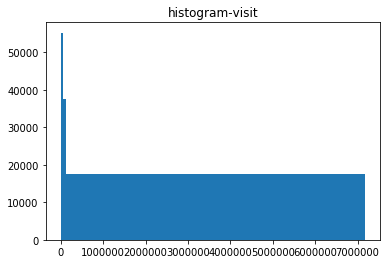

The histogram of visitor:
[55161 55200 55190 35003 20181]
[5.000000e+01 3.426000e+03 6.536000e+03 1.309200e+04 2.759100e+04
 6.113949e+06]
The number of outlier of visitor is: 20181


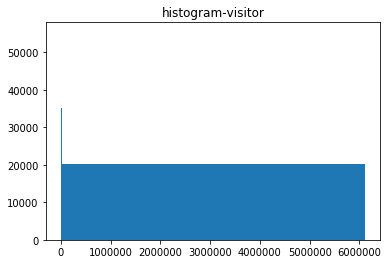

The histogram of distance:
[55178 55184 55188 29418 25767]
[7.060000e+02 8.570000e+03 1.459600e+04 3.136700e+04 6.556250e+04
 6.297845e+06]
The number of outlier of distance is: 25767


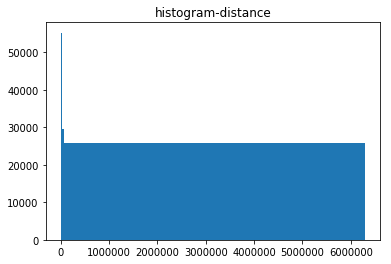

In [27]:
# 直方图
print('The histogram of visit:')
hist_visit, bins_visit = np.histogram(visit_new, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
print(hist_visit)
print(bins_visit)
print("The number of outlier of visit is:", hist_visit[-1])
plt.hist(visit, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
plt.title("histogram-visit")
plt.show()

print('The histogram of visitor:')
hist_visitor, bins_visitor = np.histogram(visitor_new, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
print(hist_visitor)
print(bins_visitor)
print("The number of outlier of visitor is:", hist_visitor[-1])
plt.hist(visitor, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
plt.title("histogram-visitor")
plt.show()

print('The histogram of distance:')
hist_distance, bins_distance = np.histogram(distance_new, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
print(hist_distance)
print(bins_distance)
print("The number of outlier of distance is:", hist_distance[-1])
plt.hist(distance, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
plt.title("histogram-distance")
plt.show()

The histogram of hour[ 1 ]:
[55122 55217 55176 41485 13735]
[     0.    1114.    1705.    2677.    5021.5 408076. ]
The number of outlier of hour[ 1 ]: 13735


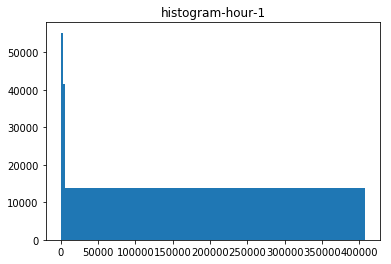

The histogram of hour[ 2 ]:
[55100 55240 55209 41712 13474]
[     0.    1059.    1611.    2512.    4691.5 414620. ]
The number of outlier of hour[ 2 ]: 13474


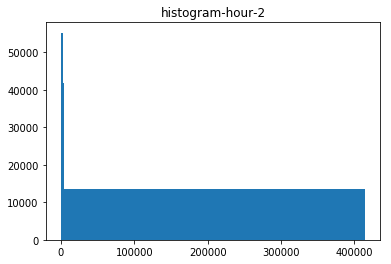

The histogram of hour[ 3 ]:
[55146 55198 55197 41708 13486]
[     0.   1033.   1567.   2439.   4548. 415050.]
The number of outlier of hour[ 3 ]: 13486


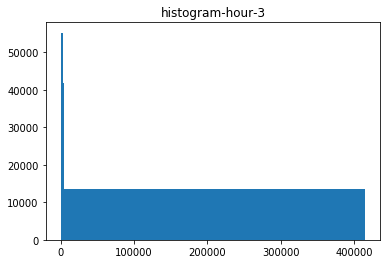

The histogram of hour[ 4 ]:
[55161 55190 55189 41699 13496]
[     0.    1024.    1556.    2427.    4531.5 423863. ]
The number of outlier of hour[ 4 ]: 13496


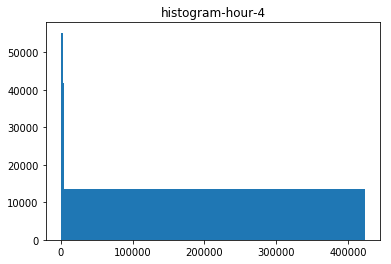

The histogram of hour[ 5 ]:
[55086 55275 55177 41378 13819]
[     0.   1053.   1614.   2547.   4788. 389655.]
The number of outlier of hour[ 5 ]: 13819


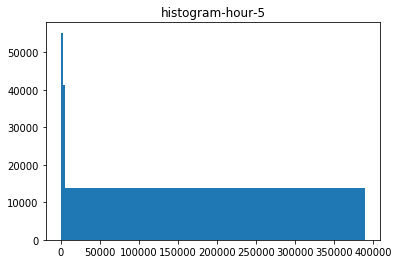

The histogram of hour[ 6 ]:
[55178 55132 55221 40475 14729]
[     0.    1153.    1788.    2884.    5480.5 374855. ]
The number of outlier of hour[ 6 ]: 14729


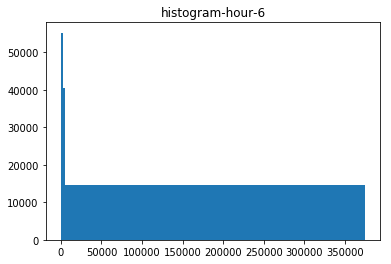

The histogram of hour[ 7 ]:
[55167 55149 55223 39129 16067]
[     0.   1394.   2231.   3742.   7264. 374740.]
The number of outlier of hour[ 7 ]: 16067


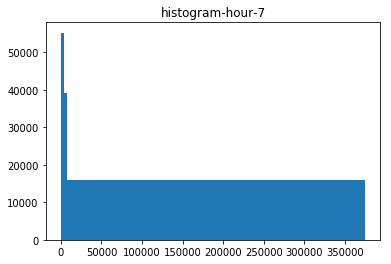

The histogram of hour[ 8 ]:
[55155 55197 55181 39629 15573]
[     0.   1865.   3114.   5351.  10580. 392794.]
The number of outlier of hour[ 8 ]: 15573


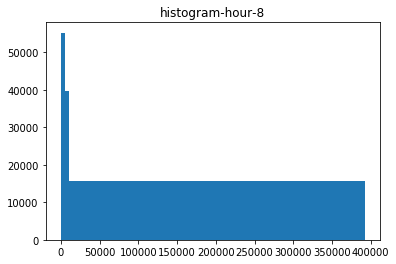

The histogram of hour[ 9 ]:
[55135 55211 55188 38639 16562]
[2.00000e+00 1.64100e+03 2.75700e+03 4.82000e+03 9.58850e+03 4.21881e+05]
The number of outlier of hour[ 9 ]: 16562


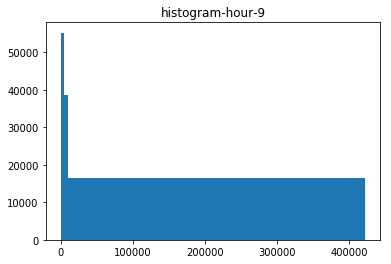

The histogram of hour[ 10 ]:
[55152 55189 55200 38183 17011]
[2.00000e+00 1.48500e+03 2.49800e+03 4.41000e+03 8.79750e+03 4.52308e+05]
The number of outlier of hour[ 10 ]: 17011


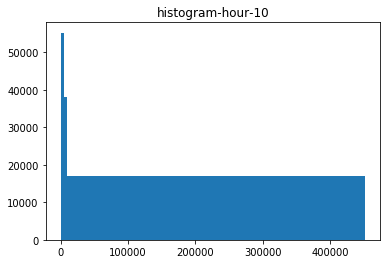

The histogram of hour[ 11 ]:
[55161 55190 55186 38049 17149]
[2.0000e+00 1.4770e+03 2.5020e+03 4.4650e+03 8.9470e+03 4.6041e+05]
The number of outlier of hour[ 11 ]: 17149


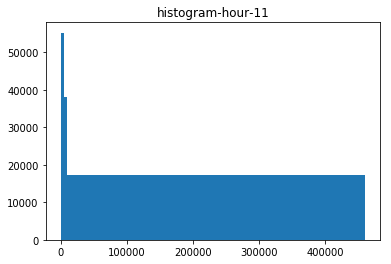

The histogram of hour[ 12 ]:
[55175 55172 55190 37924 17274]
[3.00000e+00 1.52900e+03 2.62100e+03 4.73400e+03 9.54150e+03 4.77597e+05]
The number of outlier of hour[ 12 ]: 17274


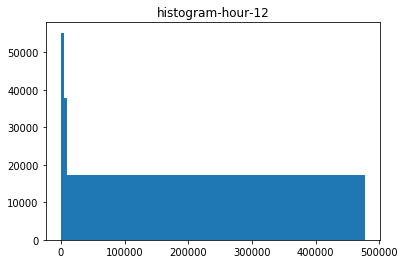

The histogram of hour[ 13 ]:
[55181 55167 55191 37879 17317]
[     0.   1597.   2763.   5025.  10167. 464389.]
The number of outlier of hour[ 13 ]: 17317


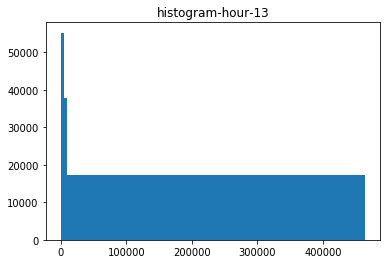

The histogram of hour[ 14 ]:
[55161 55203 55183 37746 17442]
[     0.    1588.    2744.    4991.   10095.5 447290. ]
The number of outlier of hour[ 14 ]: 17442


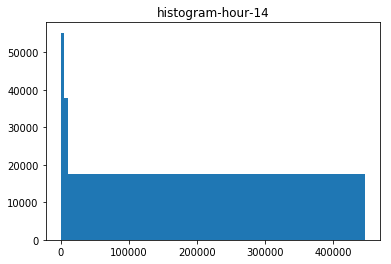

The histogram of hour[ 15 ]:
[55179 55177 55195 38237 16947]
[     0.   1732.   2974.   5342.  10757. 442044.]
The number of outlier of hour[ 15 ]: 16947


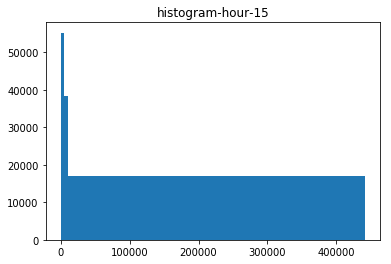

The histogram of hour[ 16 ]:
[55142 55208 55195 38698 16492]
[     0.   1947.   3321.   5901.  11832. 428866.]
The number of outlier of hour[ 16 ]: 16492


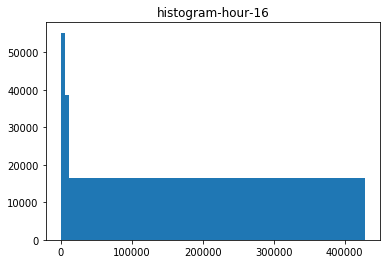

The histogram of hour[ 17 ]:
[55165 55175 55198 38375 16822]
[     0.    1987.    3382.    6020.   12069.5 411195. ]
The number of outlier of hour[ 17 ]: 16822


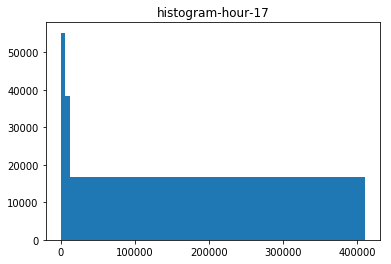

The histogram of hour[ 18 ]:
[55153 55207 55187 38654 16534]
[     0.   2053.   3495.   6183.  12378. 394592.]
The number of outlier of hour[ 18 ]: 16534


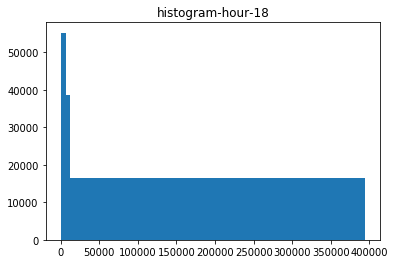

The histogram of hour[ 19 ]:
[55159 55182 55201 38853 16340]
[     0.    1892.    3181.    5533.   10994.5 341999. ]
The number of outlier of hour[ 19 ]: 16340


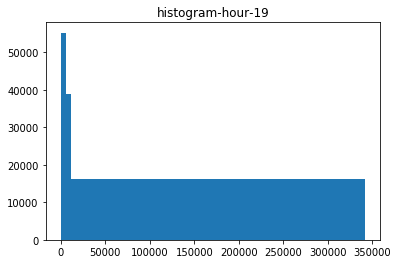

The histogram of hour[ 20 ]:
[55164 55181 55204 39207 15979]
[     0.   1693.   2783.   4749.   9333. 293178.]
The number of outlier of hour[ 20 ]: 15979


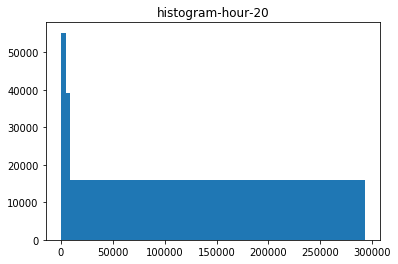

The histogram of hour[ 21 ]:
[55121 55188 55226 39679 15521]
[     0.   1565.   2521.   4203.   8160. 374411.]
The number of outlier of hour[ 21 ]: 15521


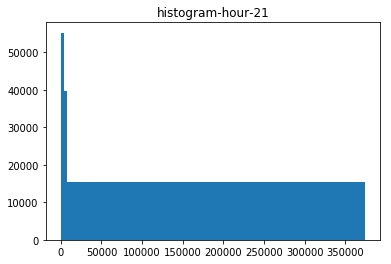

The histogram of hour[ 22 ]:
[55137 55211 55191 40053 15143]
[     0.    1456.    2303.    3755.    7203.5 377200. ]
The number of outlier of hour[ 22 ]: 15143


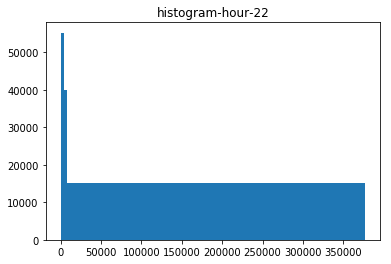

The histogram of hour[ 23 ]:
[55106 55256 55188 40558 14627]
[     0.    1323.    2066.    3318.    6310.5 379644. ]
The number of outlier of hour[ 23 ]: 14627


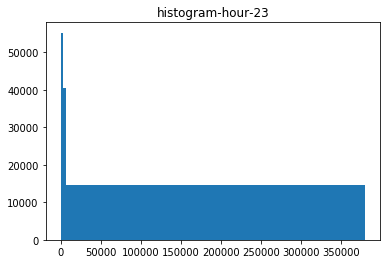

The histogram of hour[ 24 ]:
[55141 55175 55234 40986 14199]
[     0.    1206.    1860.    2957.    5583.5 396279. ]
The number of outlier of hour[ 24 ]: 14199


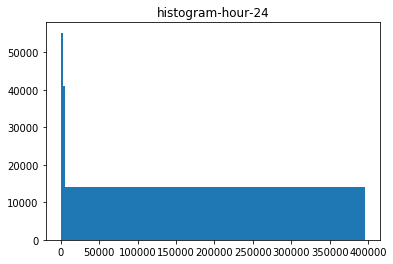

The histogram of day[ 1 ]:
[55156 55205 55184 37832 17358]
[      0.    2662.    4795.    8822.   18062. 1323997.]
The number of outlier of day[ 1 ]: 17358


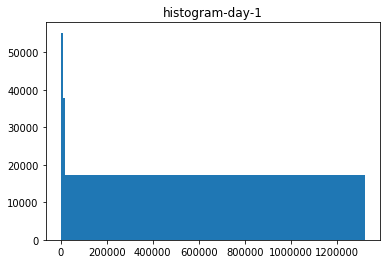

The histogram of day[ 2 ]:
[55163 55192 55194 37953 17233]
[      0.     2708.     4900.     9037.    18530.5 1209115. ]
The number of outlier of day[ 2 ]: 17233


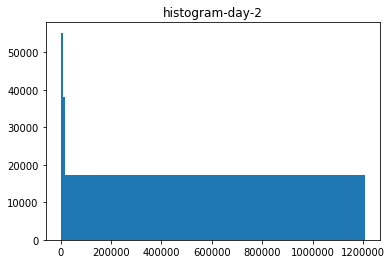

The histogram of day[ 3 ]:
[55161 55188 55202 38072 17112]
[     0.    2691.    4865.    8980.   18413.5 953888. ]
The number of outlier of day[ 3 ]: 17112


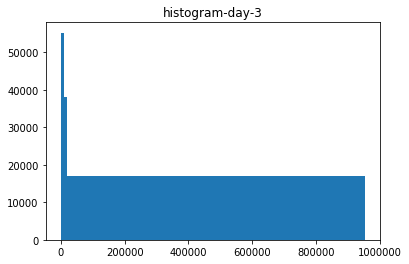

The histogram of day[ 4 ]:
[55157 55193 55200 37749 17436]
[3.00000e+00 2.21800e+03 4.03300e+03 7.48100e+03 1.53755e+04 9.50061e+05]
The number of outlier of day[ 4 ]: 17436


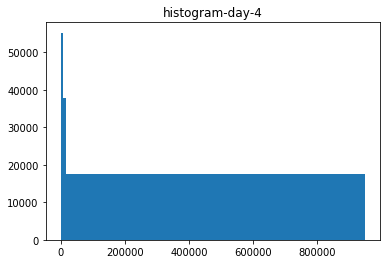

The histogram of day[ 5 ]:
[55180 55176 55191 37613 17575]
[     0.   2455.   4453.   8311.  17095. 894701.]
The number of outlier of day[ 5 ]: 17575


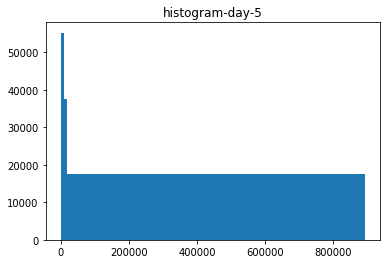

The histogram of day[ 6 ]:
[55142 55221 55176 36700 18496]
[     0.    2204.    3957.    7427.   15261.5 898361. ]
The number of outlier of day[ 6 ]: 18496


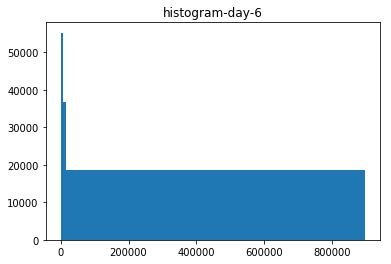

The histogram of day[ 7 ]:
[55162 55194 55194 36334 18851]
[     0.   1986.   3512.   6526.  13336. 949777.]
The number of outlier of day[ 7 ]: 18851


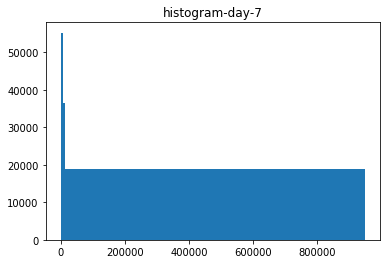

In [28]:
for i in range(24):
    print("The histogram of hour[", str(i+1), "]:")
    hist_hour, bins_hour = np.histogram(hour_new[i], bins=[mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], max_limit_hour[i], maxs_hour[i]])
    print(hist_hour)
    print(bins_hour)
    print("The number of outlier of hour[", str(i+1), "]:", hist_hour[-1])
    plt.hist(hour_new[i], bins=[mins_hour[i], Q1_hour[i], median_hour[i], Q3_hour[i], max_limit_hour[i], maxs_hour[i]])
    title = "histogram-hour-"+str(i+1)
    plt.title(title)
    plt.show()

for i in range(7):
    print("The histogram of day[", str(i+1), "]:")
    hist_day, bins_day = np.histogram(day_new[i], bins=[mins_day[i], Q1_day[i], median_day[i], Q3_day[i], max_limit_day[i], maxs_day[i]])
    print(hist_day)
    print(bins_day)
    print("The number of outlier of day[", str(i+1), "]:", hist_day[-1])
    plt.hist(day_new[i], bins=[mins_day[i], Q1_day[i], median_day[i], Q3_day[i], max_limit_day[i], maxs_day[i]])
    title = "histogram-day-"+str(i+1)
    plt.title(title)
    plt.show()

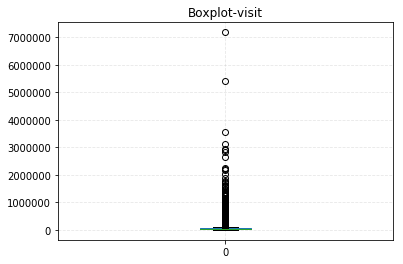

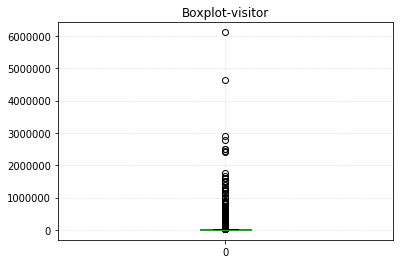

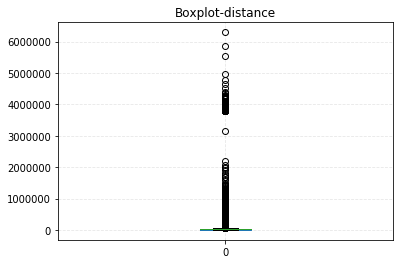

In [29]:
# 盒图
df = pd.DataFrame(visit_new)
# print(df.describe())
df.plot.box(title="Boxplot-visit")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(visitor_new)
# print(df.describe())
df.plot.box(title="Boxplot-visitor")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(distance_new)
# print(df.describe())
df.plot.box(title="Boxplot-distance")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

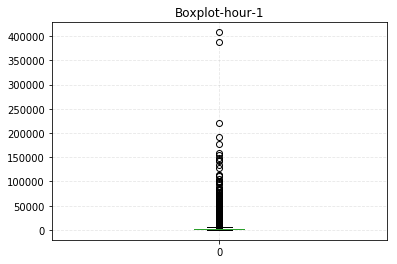

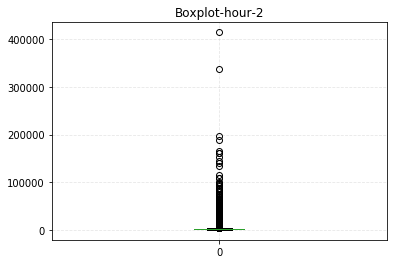

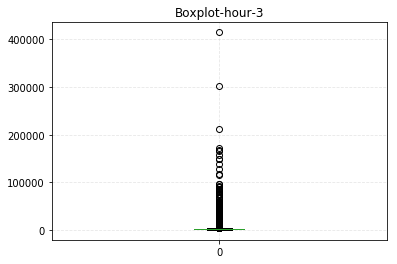

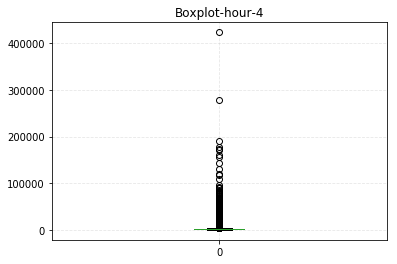

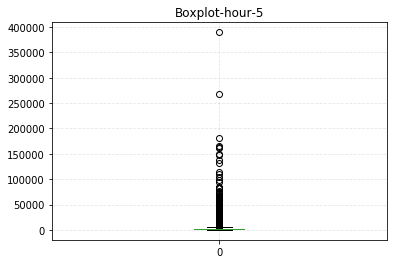

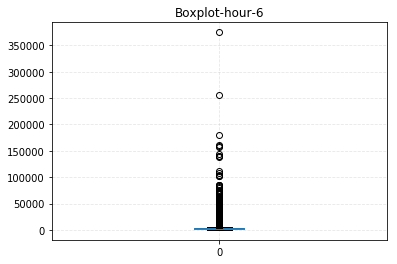

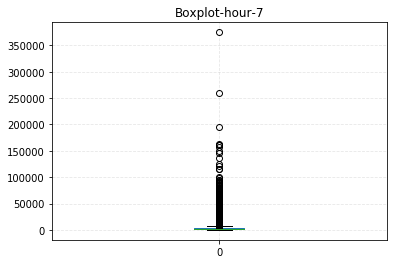

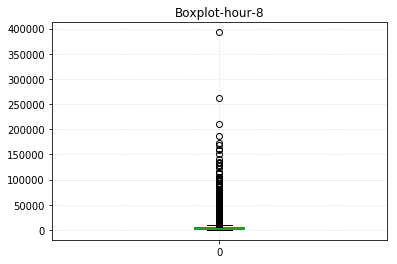

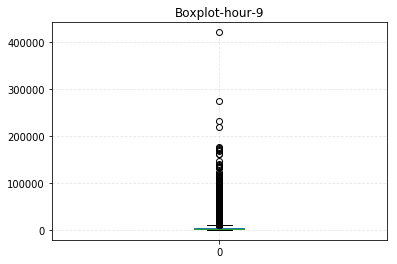

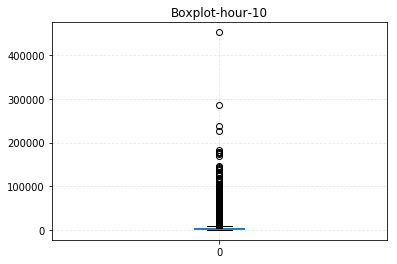

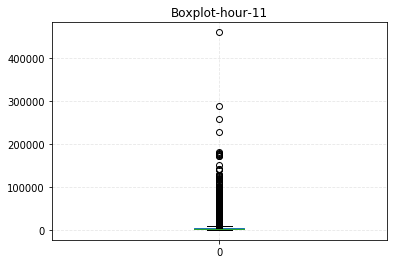

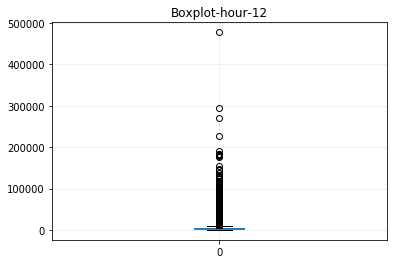

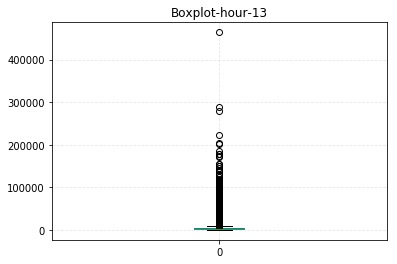

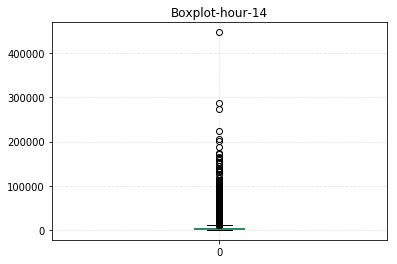

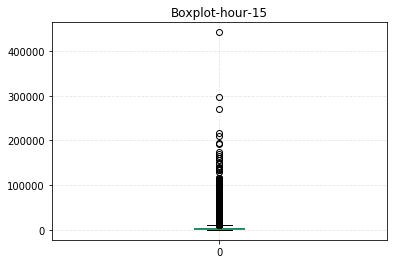

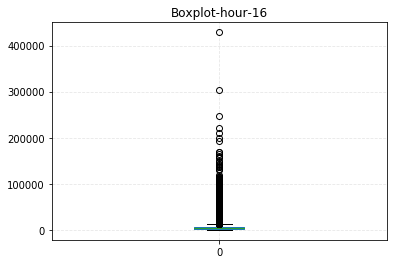

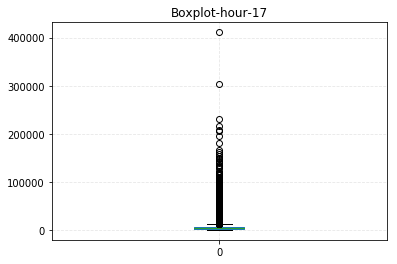

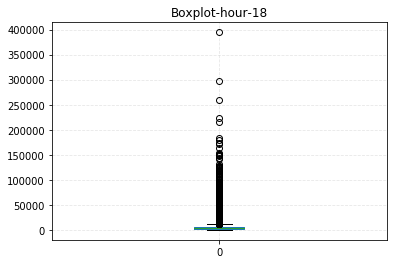

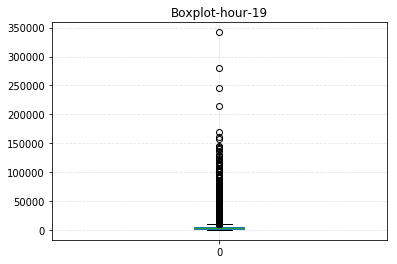

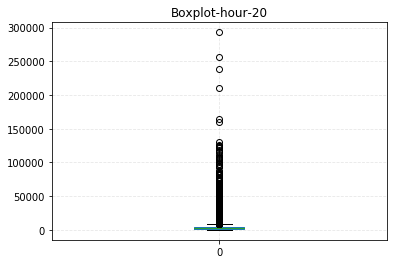

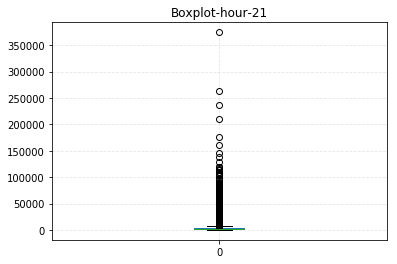

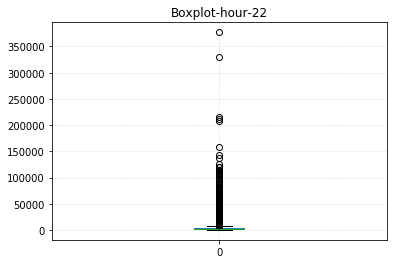

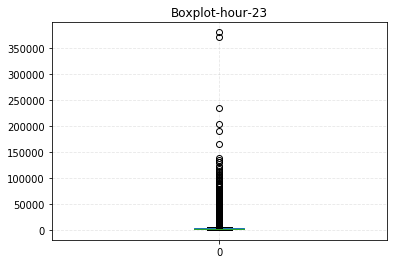

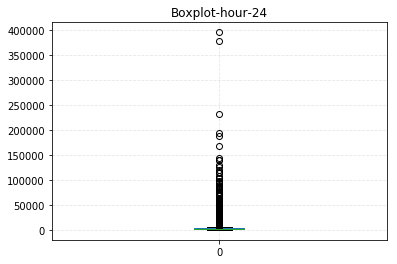

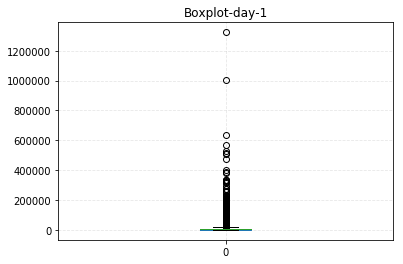

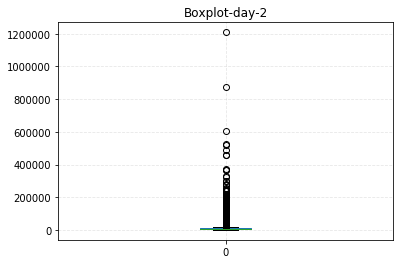

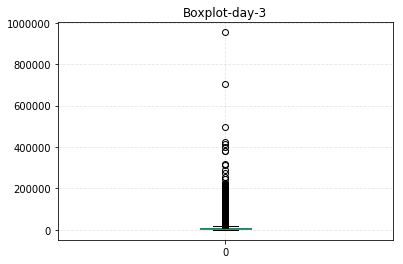

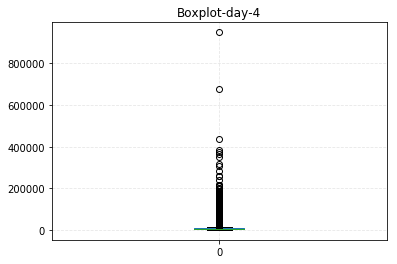

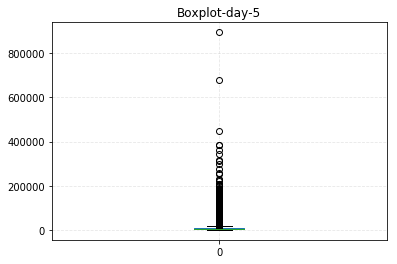

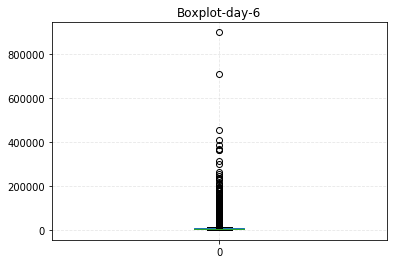

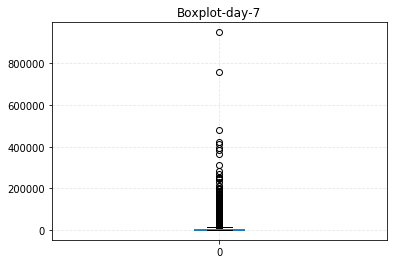

In [30]:
for i in range(24):
    df = pd.DataFrame(hour_new[i])
    # print(df.describe())
    title = "Boxplot-hour-" + str(i + 1)
    df.plot.box(title=title)
    plt.grid(linestyle="--", alpha=0.3)
    plt.show()

for i in range(7):
    df = pd.DataFrame(day_new[i])
    # print(df.describe())
    title = "Boxplot-day-" + str(i + 1)
    df.plot.box(title=title)
    plt.grid(linestyle="--", alpha=0.3)
    plt.show()

3）通过属性的相关关系来填补缺失值

用随机森林方法来拟合数据，将缺失值作为目标变量

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
# visit
df = pd.read_csv(filename, encoding="utf-8")  # df数据格式为DataFrame
df['raw_visitor_count'].fillna(df['raw_visitor_count'].mean(), inplace=True)
df['distance_from_home'].fillna(df['distance_from_home'].mean(), inplace=True)

def fill_visit_regression(df):
    df_blank = df[['raw_visit_count', 'raw_visitor_count', 'distance_from_home']]

    # 假设points需要填充的列
    known_v = df_blank[df_blank.raw_visit_count.notnull()].as_matrix()
    unknown_v = df_blank[df_blank.raw_visit_count.isnull()].as_matrix()

    # y为目标
    y = known_v[:, 0]
    # X为特征属性值
    X = known_v[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知结果预测
    predicted_v = rfr.predict(unknown_v[:, 1:])
    print(predicted_v)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.raw_visit_count.isnull()), 'raw_visit_count'] = predicted_v

    return predicted_v

print("fill visit:")
predicted_v = fill_visit_regression(df)


fill visit:
[55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300. 55300.
 55300. 55300. 55300. 55300. 55300. 55300.]


In [33]:
predicted_v = np.array(predicted_v).tolist()
visit_new = visit.tolist()
visit_new += predicted_v
visit_new = np.array(visit_new)
visit_new.sort()

In [34]:
# visitor
df = pd.read_csv(filename, encoding="utf-8")  # df数据格式为DataFrame
df['raw_visit_count'].fillna(df['raw_visit_count'].mean(), inplace=True)
df['distance_from_home'].fillna(df['distance_from_home'].mean(), inplace=True)

def fill_visitor_regression(df):
    df_blank = df[['raw_visitor_count', 'raw_visit_count', 'distance_from_home']]

    # 假设points需要填充的列
    known_v = df_blank[df_blank.raw_visitor_count.notnull()].as_matrix()
    unknown_v = df_blank[df_blank.raw_visitor_count.isnull()].as_matrix()

    # y为目标
    y = known_v[:, 0]
    # X为特征属性值
    X = known_v[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知结果预测
    predicted_v = rfr.predict(unknown_v[:, 1:])
    print(predicted_v)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.raw_visitor_count.isnull()), 'raw_visitor_count'] = predicted_v

    return predicted_v

print("fill visitor:")
predicted_v = fill_visitor_regression(df)

predicted_v = np.array(predicted_v).tolist()
visitor_new = visitor.tolist()
visitor_new += predicted_v
visitor_new = np.array(visitor_new)
visitor_new.sort()

fill visitor:
[9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015
 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 9928.0015 99

In [35]:
# distance
df = pd.read_csv(filename, encoding="utf-8")  # df数据格式为DataFrame
df['raw_visit_count'].fillna(df['raw_visit_count'].mean(), inplace=True)
df['raw_visitor_count'].fillna(df['raw_visitor_count'].mean(), inplace=True)

def fill_distance_regression(df):
    df_blank = df[['distance_from_home', 'raw_visit_count', 'raw_visitor_count']]

    # 假设points需要填充的列
    known_v = df_blank[df_blank.distance_from_home.notnull()].as_matrix()
    unknown_v = df_blank[df_blank.distance_from_home.isnull()].as_matrix()

    # y为目标
    y = known_v[:, 0]
    # X为特征属性值
    X = known_v[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知结果预测
    predicted_v = rfr.predict(unknown_v[:, 1:])
    print(predicted_v)
    # 用得到的预测结果填补原缺失数据
    df.loc[(df.distance_from_home.isnull()), 'distance_from_home'] = predicted_v

    return predicted_v

print("fill distance:")
predicted_v = fill_distance_regression(df)

predicted_v = np.array(predicted_v).tolist()
distance_new = distance.tolist()
distance_new += predicted_v
distance_new = np.array(distance_new)
distance_new.sort()

fill distance:
[  27019.0425  222235.9725   31721.1935   48199.3305  142680.597
  163141.97     53880.04     23231.95     88436.918    30216.068
   14153.126    51087.941    95775.2035  181720.0665  114511.5225
   52235.786   209285.035    94343.104    48347.874   108077.212
   49666.996    49303.9655  758535.178   100472.7205   40013.14
   49334.861    77978.193    75004.465   405631.3545   34804.4325
   45386.03     19361.9      50148.726    47328.003    23667.5755
   14862.1665   86990.2315   18228.485   903519.4025   26565.44
   44748.179   287230.407    27079.379    87777.239   300782.512
   69511.39     76237.7065 1044239.216    23662.8705   29198.8015
   20998.4885   35134.6715  220488.2555  183503.665  1906407.372
   20175.16     95042.862    80734.979   113776.538    13108.8715
   59826.5015 2805822.2995   28147.136    52235.786    57631.856
   48913.288    32437.097    57109.2055   20317.9135 1766842.5825
   20873.9455  153866.342    97917.8895   18006.569   136325.0625
   28

可视化比较

In [36]:
# 可视化分析
print("========================== Visual data analysis for related attribute ==========================")
print("========================== visit ==========================")
mins_visit = visit_new[0]
maxs_visit = visit_new[-1]
median_visit = np.median(visit_new)
Q1_visit = my_quantile(visit_new, 0.25)
Q3_visit = my_quantile(visit_new, 0.75)
print("Five number summary of visit: min, Q1, median, Q3, max")
print(mins_visit, Q1_visit, median_visit, Q3_visit, maxs_visit)
IQR_visit = Q3_visit - Q1_visit
min_limit_visit = Q1_visit - (1.5 * IQR_visit)
max_limit_visit = Q3_visit + (1.5 * IQR_visit)
print("IQR of visit:", IQR_visit)
print("The reasonable interval of visit:", min_limit_visit, max_limit_visit)

print("========================== visitor ==========================")
mins_visitor = visitor_new[0]
maxs_visitor = visitor_new[-1]
median_visitor = np.median(visitor_new)
Q1_visitor = my_quantile(visitor_new, 0.25)
Q3_visitor = my_quantile(visitor_new, 0.75)
print("Five number summary of visitor: min, Q1, median, Q3, max")
print(mins_visitor, Q1_visitor, median_visitor, Q3_visitor, maxs_visitor)
IQR_visitor = Q3_visitor - Q1_visitor
min_limit_visitor = Q1_visitor - (1.5 * IQR_visitor)
max_limit_visitor = Q3_visitor + (1.5 * IQR_visitor)
print("IQR of visitor:", IQR_visitor)
print("The reasonable interval of visitor:", min_limit_visitor, max_limit_visitor)

print("========================== distance ==========================")
mins_distance = distance_new[0]
maxs_distance = distance_new[-1]
median_distance = np.median(distance_new)
Q1_distance = my_quantile(distance_new, 0.25)
Q3_distance = my_quantile(distance_new, 0.75)
print("Five number summary of distance: min, Q1, median, Q3, max")
print(mins_distance, Q1_distance, median_distance, Q3_distance, maxs_distance)
IQR_distance = Q3_distance - Q1_distance
min_limit_distance = Q1_distance - (1.5 * IQR_distance)
max_limit_distance = Q3_distance + (1.5 * IQR_distance)
print("IQR of distance:", IQR_distance)
print("The reasonable interval of distance:", min_limit_distance, max_limit_distance)


========================== Visual data analysis for related attribute ==========================
========================== visit ==========================
Five number summary of visit: min, Q1, median, Q3, max
60.0 17047.0 30656.0 56652.0 7179900.0
IQR of visit: 39605.0
The reasonable interval of visit: -42360.5 116059.5
========================== visitor ==========================
Five number summary of visitor: min, Q1, median, Q3, max
50.0 3431.0 6544.0 13092.0 6113949.0
IQR of visitor: 9661.0
The reasonable interval of visitor: -11060.5 27583.5
========================== distance ==========================
Five number summary of distance: min, Q1, median, Q3, max
706.0 8588.0 14631.0 31412.0 6297845.0
IQR of distance: 22824.0
The reasonable interval of distance: -25648.0 65648.0


直方图和盒图

The histogram of visit:
[55180 55183 55186 37550 17636]
[6.000000e+01 1.704700e+04 3.065600e+04 5.665200e+04 1.160595e+05
 7.179900e+06]
The number of outlier of visit is: 17636


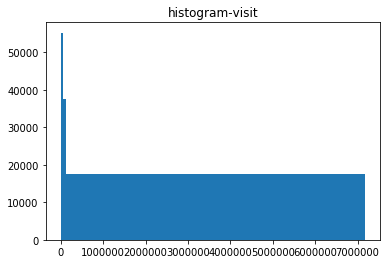

The histogram of visitor:
[55168 55191 55192 34996 20188]
[5.000000e+01 3.431000e+03 6.544000e+03 1.309200e+04 2.758350e+04
 6.113949e+06]
The number of outlier of visitor is: 20188


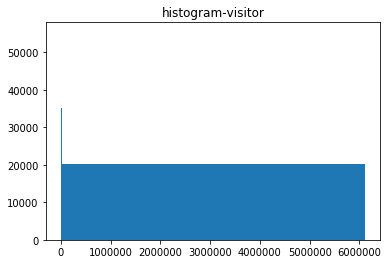

The histogram of distance:
[55167 55199 55185 29401 25783]
[7.060000e+02 8.588000e+03 1.463100e+04 3.141200e+04 6.564800e+04
 6.297845e+06]
The number of outlier of distance is: 25783


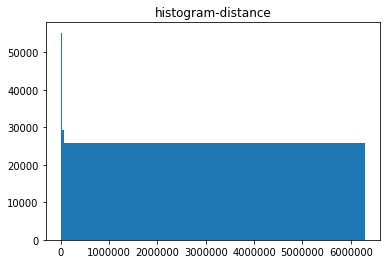

In [37]:
# 直方图
print('The histogram of visit:')
hist_visit, bins_visit = np.histogram(visit_new, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
print(hist_visit)
print(bins_visit)
print("The number of outlier of visit is:", hist_visit[-1])
plt.hist(visit, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
plt.title("histogram-visit")
plt.show()

print('The histogram of visitor:')
hist_visitor, bins_visitor = np.histogram(visitor_new, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
print(hist_visitor)
print(bins_visitor)
print("The number of outlier of visitor is:", hist_visitor[-1])
plt.hist(visitor, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
plt.title("histogram-visitor")
plt.show()

print('The histogram of distance:')
hist_distance, bins_distance = np.histogram(distance_new, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
print(hist_distance)
print(bins_distance)
print("The number of outlier of distance is:", hist_distance[-1])
plt.hist(distance, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
plt.title("histogram-distance")
plt.show()

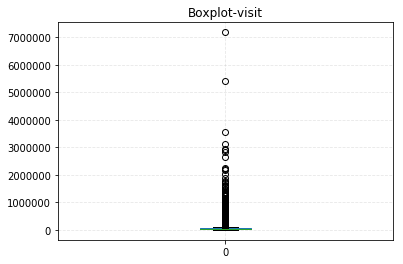

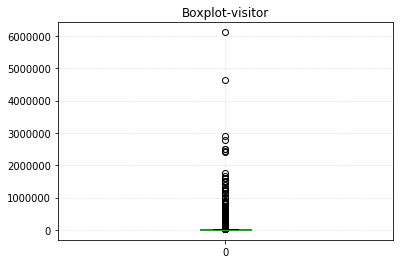

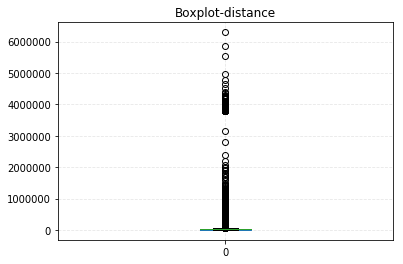

In [38]:
# 盒图
df = pd.DataFrame(visit_new)
# print(df.describe())
df.plot.box(title="Boxplot-visit")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(visitor_new)
# print(df.describe())
df.plot.box(title="Boxplot-visitor")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(distance_new)
# print(df.describe())
df.plot.box(title="Boxplot-distance")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

4）通过数据对象之间的相似性来填补缺失值

考虑对象相关性，用插值的方法来填补数据；

In [40]:
file = '/Users/yumingfei/Documents/Document/Postgraduate/课件/数据挖掘/数据集/cbg.csv'
data = pd.read_csv(filename, encoding="utf-8")  # df数据格式为DataFrame
for f in data:  # 插值法填充
    data[f] = data[f].interpolate()
data.to_csv(file, encoding="utf-8", header=False, index=False)

print("fill data with related object:")
visit_new = list()
visitor_new = list()
distance_new = list()

with open(file, 'r') as finnew:
    reader = csv.reader(finnew)
    rownum = 0

    # 每一行数据
    for line in reader:
        if header and rownum == 0:
            header = line
            print('header: ', header)
        else:
            vc = line[3]
            vrc = line[4]
            dc = line[7]
            visit_new.append(float(vc))
            visitor_new.append(float(vrc))
            distance_new.append(float(dc))

        rownum += 1
        # if rownum == 3:
        #     break

visit_new = np.array(visit_new)
visit_new.sort()
visitor_new = np.array(visitor_new)
visitor_new.sort()
distance_new = np.array(distance_new)
distance_new.sort()

fill data with related object:
header:  ['10059508001.0', '1538352000', '1541030400', '75122.0', '18314.0', '{"010059501003":127,"010059509001":111,"010059509002":106,"010059505001":102,"010059506002":92,"010059508002":82,"010059505003":64,"010059501002":61,"010059507002":58,"010690402011":57,"010690402021":56,"132399603002":51,"130619603001":51,"010670303001":50}', '{"010059501003":109,"010810407002":62,"010810420061":55,"010690402024":54}', '194724.0', '["Chick-fil-A","mcdonalds","Marathon Petroleum","walmart"]', '["walmart","mcdonalds","Dollar General","Chick-fil-A","Marathon Petroleum","Shell Oil","Waffle House","SUBWAY","Publix Super Markets","Circle K Stores"]', '["CrossFit","Health Mart","Coldwell Banker"]', '[2617,2457,2403,2519,2646,3007,3886,7566,5508,5663,6004,6861,7411,6781,6769,8389,7113,7199,6001,5513,4453,3886,3611,3008]', '{"Monday":12000,"Tuesday":12224,"Wednesday":10626,"Thursday":9923,"Friday":12116,"Saturday":9516,"Sunday":8717}']


可视化比较

In [41]:
# 可视化分析
print("========================== Visual data analysis for related object ==========================")
print("========================== visit ==========================")
mins_visit = visit_new[0]
maxs_visit = visit_new[-1]
median_visit = np.median(visit_new)
Q1_visit = my_quantile(visit_new, 0.25)
Q3_visit = my_quantile(visit_new, 0.75)
print("Five number summary of visit: min, Q1, median, Q3, max")
print(mins_visit, Q1_visit, median_visit, Q3_visit, maxs_visit)
IQR_visit = Q3_visit - Q1_visit
min_limit_visit = Q1_visit - (1.5 * IQR_visit)
max_limit_visit = Q3_visit + (1.5 * IQR_visit)
print("IQR of visit:", IQR_visit)
print("The reasonable interval of visit:", min_limit_visit, max_limit_visit)

print("========================== visitor ==========================")
mins_visitor = visitor_new[0]
maxs_visitor = visitor_new[-1]
median_visitor = np.median(visitor_new)
Q1_visitor = my_quantile(visitor_new, 0.25)
Q3_visitor = my_quantile(visitor_new, 0.75)
print("Five number summary of visitor: min, Q1, median, Q3, max")
print(mins_visitor, Q1_visitor, median_visitor, Q3_visitor, maxs_visitor)
IQR_visitor = Q3_visitor - Q1_visitor
min_limit_visitor = Q1_visitor - (1.5 * IQR_visitor)
max_limit_visitor = Q3_visitor + (1.5 * IQR_visitor)
print("IQR of visitor:", IQR_visitor)
print("The reasonable interval of visitor:", min_limit_visitor, max_limit_visitor)

print("========================== distance ==========================")
mins_distance = distance_new[0]
maxs_distance = distance_new[-1]
median_distance = np.median(distance_new)
Q1_distance = my_quantile(distance_new, 0.25)
Q3_distance = my_quantile(distance_new, 0.75)
print("Five number summary of distance: min, Q1, median, Q3, max")
print(mins_distance, Q1_distance, median_distance, Q3_distance, maxs_distance)
IQR_distance = Q3_distance - Q1_distance
min_limit_distance = Q1_distance - (1.5 * IQR_distance)
max_limit_distance = Q3_distance + (1.5 * IQR_distance)
print("IQR of distance:", IQR_distance)
print("The reasonable interval of distance:", min_limit_distance, max_limit_distance)


========================== Visual data analysis for related object ==========================
========================== visit ==========================
Five number summary of visit: min, Q1, median, Q3, max
60.0 17027.0 30625.0 56652.0 7179900.0
IQR of visit: 39625.0
The reasonable interval of visit: -42410.5 116089.5
========================== visitor ==========================
Five number summary of visitor: min, Q1, median, Q3, max
50.0 3426.0 6536.0 13091.25 6113949.0
IQR of visitor: 9665.25
The reasonable interval of visitor: -11071.875 27589.125
========================== distance ==========================
Five number summary of distance: min, Q1, median, Q3, max
706.0 8577.0 14605.0 31393.0 6297845.0
IQR of distance: 22816.0
The reasonable interval of distance: -25647.0 65617.0


直方图和盒图

The histogram of visit:
[55179 55187 55183 37556 17629]
[6.000000e+01 1.702700e+04 3.062500e+04 5.665200e+04 1.160895e+05
 7.179900e+06]
The number of outlier of visit is: 17629


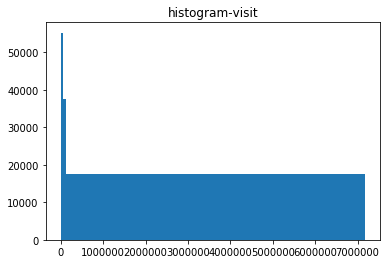

The histogram of visitor:
[55161 55200 55190 35001 20182]
[5.0000000e+01 3.4260000e+03 6.5360000e+03 1.3091250e+04 2.7589125e+04
 6.1139490e+06]
The number of outlier of visitor is: 20182


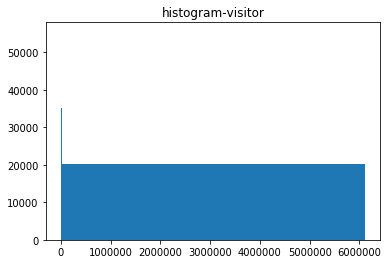

The histogram of distance:
[55178 55187 55185 29419 25765]
[7.060000e+02 8.577000e+03 1.460500e+04 3.139300e+04 6.561700e+04
 6.297845e+06]
The number of outlier of distance is: 25765


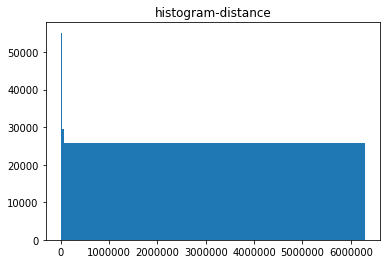

In [42]:
# 直方图
print('The histogram of visit:')
hist_visit, bins_visit = np.histogram(visit_new, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
print(hist_visit)
print(bins_visit)
print("The number of outlier of visit is:", hist_visit[-1])
plt.hist(visit, bins=[mins_visit, Q1_visit, median_visit, Q3_visit, max_limit_visit, maxs_visit])
plt.title("histogram-visit")
plt.show()

print('The histogram of visitor:')
hist_visitor, bins_visitor = np.histogram(visitor_new, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
print(hist_visitor)
print(bins_visitor)
print("The number of outlier of visitor is:", hist_visitor[-1])
plt.hist(visitor, bins=[mins_visitor, Q1_visitor, median_visitor, Q3_visitor, max_limit_visitor, maxs_visitor])
plt.title("histogram-visitor")
plt.show()

print('The histogram of distance:')
hist_distance, bins_distance = np.histogram(distance_new, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
print(hist_distance)
print(bins_distance)
print("The number of outlier of distance is:", hist_distance[-1])
plt.hist(distance, bins=[mins_distance, Q1_distance, median_distance, Q3_distance, max_limit_distance, maxs_distance])
plt.title("histogram-distance")
plt.show()

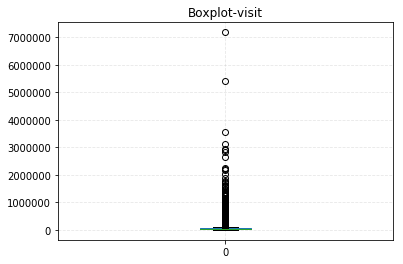

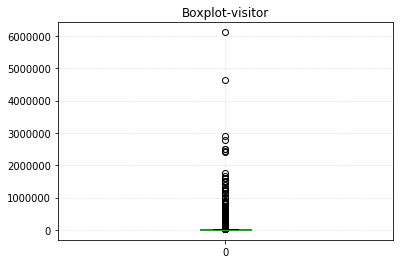

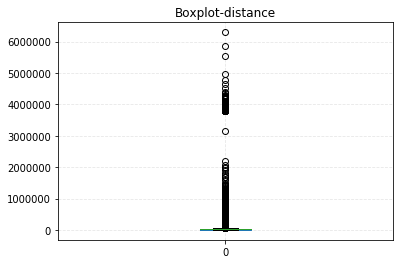

In [43]:
# 盒图
df = pd.DataFrame(visit_new)
# print(df.describe())
df.plot.box(title="Boxplot-visit")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(visitor_new)
# print(df.describe())
df.plot.box(title="Boxplot-visitor")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

df = pd.DataFrame(distance_new)
# print(df.describe())
df.plot.box(title="Boxplot-distance")
plt.grid(linestyle="--", alpha=0.3)
plt.show()
